# Ingénierie des données graphes avec Neo4j, Spark et GraphFrames

Ce notebook est une adaptation inspirée et étendue du notebook suivant : https://github.com/neo4j/neo4j-spark-connector/tree/5.0/examples 

Vous pouvez trouver la documentation de Neo4j et GraphFrames utilisées ci-dessous (vous en aurez besoin pour ce TP !):
- [neo4j](https://neo4j.com/developer/)
- [GraphFrames](https://graphframes.github.io/graphframes/docs/_site/index.html)

------

   
This notebook contains a set of examples that explains how to extract insights from data using the Neo4j Connector for Apache Spark in a Data Engineering workflow.
                                                                                                                  
After exploring the basics of the Neo4j Spark connector, we will show one method to go further into the analytics domain using the Spark GraphFrames API. 

In [1]:
neo4j_url = "neo4j://neo4j:7687" # put your neo4j url here
neo4j_user = "neo4j" # put your neo4j user here
neo4j_password = "neo4jtp9" # put your neo4j password here

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
import docker

spark = (SparkSession.builder
        .master('spark://spark:7077')
        .appName('Data engineering workflow with Neo4j and Spark')
        .config('spark.ui.port', '4050')
        # Just to show dataframes as tables
        .config('spark.sql.repl.eagerEval.enabled', True)
        .config('spark.jars.packages', 'org.neo4j:neo4j-connector-apache-spark_2.12:5.1.0_for_spark_3,graphframes:graphframes:0.8.4-spark3.5-s_2.12')
        # As we're using always the same database instance we'll
        # define them as global variables
        # so we don't need to repeat them each time
        .config("neo4j.url", neo4j_url)
        .config("neo4j.authentication.type", "basic")
        .config("neo4j.authentication.scheme", "basic")
        .config("neo4j.authentication.basic.username", neo4j_user)
        .config("neo4j.authentication.basic.password", neo4j_password)
        .getOrCreate())

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-602e0fcd-5306-47ff-be49-c0b8a6f936d7;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.12;5.1.0_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12_common;5.1.0 in central
	found org.neo4j.driver#neo4j-java-driver;4.4.12 in central
	found org.reactivestreams#reactive-streams;1.0.4 in central
	found org.apache.xbean#xbean-asm6-shaded;4.10 in central
	found org.neo4j#neo4j-cypher-dsl;2022.9.0 in central
	found org.apiguardian#apiguardian-api;1.1.2 in central
	found graphframes#graphframes;0.8.4-spark3.5-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 475ms :: artifacts dl 29ms
	:: modules in use:
	graphframes


## Exercises prerequisite

In this notebook we and going to test your knowledge. Some of the exercises require the Neo4j Python driver to check if the exercises are being solved correctly.

*Neo4j Python Driver is required only for verifying the exercises when you persist data from Spark to Neo4j*

**It's not required by the Spark connector!!!**

We'll use [Cy2Py](https://github.com/conker84/cy2py), a Jupyter extension that easily allows you to connect to Neo4j and visualize data from Jupyter notebooks.
For a detailed instruction about how to use it please dive into [this example](https://github.com/conker84/cy2py/blob/main/examples/Neo4j_Crime_Investigation_Dataset.ipynb)

## Load cy2py:

In [3]:
%pip install cy2py ipycytoscape
%load_ext cy2py

Note: you may need to restart the kernel to use updated packages.


To use cy2py, you may first check the %cypher? manual using the following cell 

In [4]:
%cypher?

Docstring:
::

  %cypher [-a ALIAS] [-u URI] [-us USERNAME] [-pw PASSWORD] [-db DATABASE]
              [-q QUERY] [-p PARAMS] [-c CLOSE] [-co COLORS] [-ca CAPTIONS]
              [-la LAYOUT] [-l]

options:
  -a ALIAS, --alias ALIAS
                        The Neo4j connection configuration alias. You after
                        you defined it the first time in combination with the
                        other arguments you can use only it to connect to the
                        Neo4j instance without repassing the arguments each
                        time. If you don't specify it the first time you'll
                        pass the config it'll became the default for each
                        connection
  -u URI, --uri URI     The Neo4j URI. You can use this kind of URI in order
                        to define a specific database to query:
                        neo4j://localhost:7687/my-db
  -us USERNAME, --username USERNAME
                        The Neo4j User
  -p

#### Populate the database

To perform this section go in the Neo4j Brower of your local (docker) instance [here](http://localhost:7474) using the same credentials as your session defined above (`neo4j:neo4jtp9`) and paste the following query:

<details>
<summary>
Show the Cypher query
</summary>

```cypher
CREATE (TheMatrix:Movie {title:'The Matrix', released:1999, tagline:'Welcome to the Real World'})
CREATE (Keanu:Person {name:'Keanu Reeves', born:1964})
CREATE (Carrie:Person {name:'Carrie-Anne Moss', born:1967})
CREATE (Laurence:Person {name:'Laurence Fishburne', born:1961})
CREATE (Hugo:Person {name:'Hugo Weaving', born:1960})
CREATE (LillyW:Person {name:'Lilly Wachowski', born:1967})
CREATE (LanaW:Person {name:'Lana Wachowski', born:1965})
CREATE (JoelS:Person {name:'Joel Silver', born:1952})
CREATE
(Keanu)-[:ACTED_IN {roles:['Neo']}]->(TheMatrix),
(Carrie)-[:ACTED_IN {roles:['Trinity']}]->(TheMatrix),
(Laurence)-[:ACTED_IN {roles:['Morpheus']}]->(TheMatrix),
(Hugo)-[:ACTED_IN {roles:['Agent Smith']}]->(TheMatrix),
(LillyW)-[:DIRECTED]->(TheMatrix),
(LanaW)-[:DIRECTED]->(TheMatrix),
(JoelS)-[:PRODUCED]->(TheMatrix)

CREATE (Emil:Person {name:"Emil Eifrem", born:1978})
CREATE (Emil)-[:ACTED_IN {roles:["Emil"]}]->(TheMatrix)

CREATE (TheMatrixReloaded:Movie {title:'The Matrix Reloaded', released:2003, tagline:'Free your mind'})
CREATE
(Keanu)-[:ACTED_IN {roles:['Neo']}]->(TheMatrixReloaded),
(Carrie)-[:ACTED_IN {roles:['Trinity']}]->(TheMatrixReloaded),
(Laurence)-[:ACTED_IN {roles:['Morpheus']}]->(TheMatrixReloaded),
(Hugo)-[:ACTED_IN {roles:['Agent Smith']}]->(TheMatrixReloaded),
(LillyW)-[:DIRECTED]->(TheMatrixReloaded),
(LanaW)-[:DIRECTED]->(TheMatrixReloaded),
(JoelS)-[:PRODUCED]->(TheMatrixReloaded)

CREATE (TheMatrixRevolutions:Movie {title:'The Matrix Revolutions', released:2003, tagline:'Everything that has a beginning has an end'})
CREATE
(Keanu)-[:ACTED_IN {roles:['Neo']}]->(TheMatrixRevolutions),
(Carrie)-[:ACTED_IN {roles:['Trinity']}]->(TheMatrixRevolutions),
(Laurence)-[:ACTED_IN {roles:['Morpheus']}]->(TheMatrixRevolutions),
(Hugo)-[:ACTED_IN {roles:['Agent Smith']}]->(TheMatrixRevolutions),
(LillyW)-[:DIRECTED]->(TheMatrixRevolutions),
(LanaW)-[:DIRECTED]->(TheMatrixRevolutions),
(JoelS)-[:PRODUCED]->(TheMatrixRevolutions)

CREATE (TheDevilsAdvocate:Movie {title:"The Devil's Advocate", released:1997, tagline:'Evil has its winning ways'})
CREATE (Charlize:Person {name:'Charlize Theron', born:1975})
CREATE (Al:Person {name:'Al Pacino', born:1940})
CREATE (Taylor:Person {name:'Taylor Hackford', born:1944})
CREATE
(Keanu)-[:ACTED_IN {roles:['Kevin Lomax']}]->(TheDevilsAdvocate),
(Charlize)-[:ACTED_IN {roles:['Mary Ann Lomax']}]->(TheDevilsAdvocate),
(Al)-[:ACTED_IN {roles:['John Milton']}]->(TheDevilsAdvocate),
(Taylor)-[:DIRECTED]->(TheDevilsAdvocate)

CREATE (AFewGoodMen:Movie {title:"A Few Good Men", released:1992, tagline:"In the heart of the nation's capital, in a courthouse of the U.S. government, one man will stop at nothing to keep his honor, and one will stop at nothing to find the truth."})
CREATE (TomC:Person {name:'Tom Cruise', born:1962})
CREATE (JackN:Person {name:'Jack Nicholson', born:1937})
CREATE (DemiM:Person {name:'Demi Moore', born:1962})
CREATE (KevinB:Person {name:'Kevin Bacon', born:1958})
CREATE (KieferS:Person {name:'Kiefer Sutherland', born:1966})
CREATE (NoahW:Person {name:'Noah Wyle', born:1971})
CREATE (CubaG:Person {name:'Cuba Gooding Jr.', born:1968})
CREATE (KevinP:Person {name:'Kevin Pollak', born:1957})
CREATE (JTW:Person {name:'J.T. Walsh', born:1943})
CREATE (JamesM:Person {name:'James Marshall', born:1967})
CREATE (ChristopherG:Person {name:'Christopher Guest', born:1948})
CREATE (RobR:Person {name:'Rob Reiner', born:1947})
CREATE (AaronS:Person {name:'Aaron Sorkin', born:1961})
CREATE
(TomC)-[:ACTED_IN {roles:['Lt. Daniel Kaffee']}]->(AFewGoodMen),
(JackN)-[:ACTED_IN {roles:['Col. Nathan R. Jessup']}]->(AFewGoodMen),
(DemiM)-[:ACTED_IN {roles:['Lt. Cdr. JoAnne Galloway']}]->(AFewGoodMen),
(KevinB)-[:ACTED_IN {roles:['Capt. Jack Ross']}]->(AFewGoodMen),
(KieferS)-[:ACTED_IN {roles:['Lt. Jonathan Kendrick']}]->(AFewGoodMen),
(NoahW)-[:ACTED_IN {roles:['Cpl. Jeffrey Barnes']}]->(AFewGoodMen),
(CubaG)-[:ACTED_IN {roles:['Cpl. Carl Hammaker']}]->(AFewGoodMen),
(KevinP)-[:ACTED_IN {roles:['Lt. Sam Weinberg']}]->(AFewGoodMen),
(JTW)-[:ACTED_IN {roles:['Lt. Col. Matthew Andrew Markinson']}]->(AFewGoodMen),
(JamesM)-[:ACTED_IN {roles:['Pfc. Louden Downey']}]->(AFewGoodMen),
(ChristopherG)-[:ACTED_IN {roles:['Dr. Stone']}]->(AFewGoodMen),
(AaronS)-[:ACTED_IN {roles:['Man in Bar']}]->(AFewGoodMen),
(RobR)-[:DIRECTED]->(AFewGoodMen),
(AaronS)-[:WROTE]->(AFewGoodMen)

CREATE (TopGun:Movie {title:"Top Gun", released:1986, tagline:'I feel the need, the need for speed.'})
CREATE (KellyM:Person {name:'Kelly McGillis', born:1957})
CREATE (ValK:Person {name:'Val Kilmer', born:1959})
CREATE (AnthonyE:Person {name:'Anthony Edwards', born:1962})
CREATE (TomS:Person {name:'Tom Skerritt', born:1933})
CREATE (MegR:Person {name:'Meg Ryan', born:1961})
CREATE (TonyS:Person {name:'Tony Scott', born:1944})
CREATE (JimC:Person {name:'Jim Cash', born:1941})
CREATE
(TomC)-[:ACTED_IN {roles:['Maverick']}]->(TopGun),
(KellyM)-[:ACTED_IN {roles:['Charlie']}]->(TopGun),
(ValK)-[:ACTED_IN {roles:['Iceman']}]->(TopGun),
(AnthonyE)-[:ACTED_IN {roles:['Goose']}]->(TopGun),
(TomS)-[:ACTED_IN {roles:['Viper']}]->(TopGun),
(MegR)-[:ACTED_IN {roles:['Carole']}]->(TopGun),
(TonyS)-[:DIRECTED]->(TopGun),
(JimC)-[:WROTE]->(TopGun)

CREATE (JerryMaguire:Movie {title:'Jerry Maguire', released:2000, tagline:'The rest of his life begins now.'})
CREATE (ReneeZ:Person {name:'Renee Zellweger', born:1969})
CREATE (KellyP:Person {name:'Kelly Preston', born:1962})
CREATE (JerryO:Person {name:"Jerry O'Connell", born:1974})
CREATE (JayM:Person {name:'Jay Mohr', born:1970})
CREATE (BonnieH:Person {name:'Bonnie Hunt', born:1961})
CREATE (ReginaK:Person {name:'Regina King', born:1971})
CREATE (JonathanL:Person {name:'Jonathan Lipnicki', born:1996})
CREATE (CameronC:Person {name:'Cameron Crowe', born:1957})
CREATE
(TomC)-[:ACTED_IN {roles:['Jerry Maguire']}]->(JerryMaguire),
(CubaG)-[:ACTED_IN {roles:['Rod Tidwell']}]->(JerryMaguire),
(ReneeZ)-[:ACTED_IN {roles:['Dorothy Boyd']}]->(JerryMaguire),
(KellyP)-[:ACTED_IN {roles:['Avery Bishop']}]->(JerryMaguire),
(JerryO)-[:ACTED_IN {roles:['Frank Cushman']}]->(JerryMaguire),
(JayM)-[:ACTED_IN {roles:['Bob Sugar']}]->(JerryMaguire),
(BonnieH)-[:ACTED_IN {roles:['Laurel Boyd']}]->(JerryMaguire),
(ReginaK)-[:ACTED_IN {roles:['Marcee Tidwell']}]->(JerryMaguire),
(JonathanL)-[:ACTED_IN {roles:['Ray Boyd']}]->(JerryMaguire),
(CameronC)-[:DIRECTED]->(JerryMaguire),
(CameronC)-[:PRODUCED]->(JerryMaguire),
(CameronC)-[:WROTE]->(JerryMaguire)

CREATE (StandByMe:Movie {title:"Stand By Me", released:1986, tagline:"For some, it's the last real taste of innocence, and the first real taste of life. But for everyone, it's the time that memories are made of."})
CREATE (RiverP:Person {name:'River Phoenix', born:1970})
CREATE (CoreyF:Person {name:'Corey Feldman', born:1971})
CREATE (WilW:Person {name:'Wil Wheaton', born:1972})
CREATE (JohnC:Person {name:'John Cusack', born:1966})
CREATE (MarshallB:Person {name:'Marshall Bell', born:1942})
CREATE
(WilW)-[:ACTED_IN {roles:['Gordie Lachance']}]->(StandByMe),
(RiverP)-[:ACTED_IN {roles:['Chris Chambers']}]->(StandByMe),
(JerryO)-[:ACTED_IN {roles:['Vern Tessio']}]->(StandByMe),
(CoreyF)-[:ACTED_IN {roles:['Teddy Duchamp']}]->(StandByMe),
(JohnC)-[:ACTED_IN {roles:['Denny Lachance']}]->(StandByMe),
(KieferS)-[:ACTED_IN {roles:['Ace Merrill']}]->(StandByMe),
(MarshallB)-[:ACTED_IN {roles:['Mr. Lachance']}]->(StandByMe),
(RobR)-[:DIRECTED]->(StandByMe)

CREATE (AsGoodAsItGets:Movie {title:'As Good as It Gets', released:1997, tagline:'A comedy from the heart that goes for the throat.'})
CREATE (HelenH:Person {name:'Helen Hunt', born:1963})
CREATE (GregK:Person {name:'Greg Kinnear', born:1963})
CREATE (JamesB:Person {name:'James L. Brooks', born:1940})
CREATE
(JackN)-[:ACTED_IN {roles:['Melvin Udall']}]->(AsGoodAsItGets),
(HelenH)-[:ACTED_IN {roles:['Carol Connelly']}]->(AsGoodAsItGets),
(GregK)-[:ACTED_IN {roles:['Simon Bishop']}]->(AsGoodAsItGets),
(CubaG)-[:ACTED_IN {roles:['Frank Sachs']}]->(AsGoodAsItGets),
(JamesB)-[:DIRECTED]->(AsGoodAsItGets)

CREATE (WhatDreamsMayCome:Movie {title:'What Dreams May Come', released:1998, tagline:'After life there is more. The end is just the beginning.'})
CREATE (AnnabellaS:Person {name:'Annabella Sciorra', born:1960})
CREATE (MaxS:Person {name:'Max von Sydow', born:1929})
CREATE (WernerH:Person {name:'Werner Herzog', born:1942})
CREATE (Robin:Person {name:'Robin Williams', born:1951})
CREATE (VincentW:Person {name:'Vincent Ward', born:1956})
CREATE
(Robin)-[:ACTED_IN {roles:['Chris Nielsen']}]->(WhatDreamsMayCome),
(CubaG)-[:ACTED_IN {roles:['Albert Lewis']}]->(WhatDreamsMayCome),
(AnnabellaS)-[:ACTED_IN {roles:['Annie Collins-Nielsen']}]->(WhatDreamsMayCome),
(MaxS)-[:ACTED_IN {roles:['The Tracker']}]->(WhatDreamsMayCome),
(WernerH)-[:ACTED_IN {roles:['The Face']}]->(WhatDreamsMayCome),
(VincentW)-[:DIRECTED]->(WhatDreamsMayCome)

CREATE (SnowFallingonCedars:Movie {title:'Snow Falling on Cedars', released:1999, tagline:'First loves last. Forever.'})
CREATE (EthanH:Person {name:'Ethan Hawke', born:1970})
CREATE (RickY:Person {name:'Rick Yune', born:1971})
CREATE (JamesC:Person {name:'James Cromwell', born:1940})
CREATE (ScottH:Person {name:'Scott Hicks', born:1953})
CREATE
(EthanH)-[:ACTED_IN {roles:['Ishmael Chambers']}]->(SnowFallingonCedars),
(RickY)-[:ACTED_IN {roles:['Kazuo Miyamoto']}]->(SnowFallingonCedars),
(MaxS)-[:ACTED_IN {roles:['Nels Gudmundsson']}]->(SnowFallingonCedars),
(JamesC)-[:ACTED_IN {roles:['Judge Fielding']}]->(SnowFallingonCedars),
(ScottH)-[:DIRECTED]->(SnowFallingonCedars)

CREATE (YouveGotMail:Movie {title:"You've Got Mail", released:1998, tagline:'At odds in life... in love on-line.'})
CREATE (ParkerP:Person {name:'Parker Posey', born:1968})
CREATE (DaveC:Person {name:'Dave Chappelle', born:1973})
CREATE (SteveZ:Person {name:'Steve Zahn', born:1967})
CREATE (TomH:Person {name:'Tom Hanks', born:1956})
CREATE (NoraE:Person {name:'Nora Ephron', born:1941})
CREATE
(TomH)-[:ACTED_IN {roles:['Joe Fox']}]->(YouveGotMail),
(MegR)-[:ACTED_IN {roles:['Kathleen Kelly']}]->(YouveGotMail),
(GregK)-[:ACTED_IN {roles:['Frank Navasky']}]->(YouveGotMail),
(ParkerP)-[:ACTED_IN {roles:['Patricia Eden']}]->(YouveGotMail),
(DaveC)-[:ACTED_IN {roles:['Kevin Jackson']}]->(YouveGotMail),
(SteveZ)-[:ACTED_IN {roles:['George Pappas']}]->(YouveGotMail),
(NoraE)-[:DIRECTED]->(YouveGotMail)

CREATE (SleeplessInSeattle:Movie {title:'Sleepless in Seattle', released:1993, tagline:'What if someone you never met, someone you never saw, someone you never knew was the only someone for you?'})
CREATE (RitaW:Person {name:'Rita Wilson', born:1956})
CREATE (BillPull:Person {name:'Bill Pullman', born:1953})
CREATE (VictorG:Person {name:'Victor Garber', born:1949})
CREATE (RosieO:Person {name:"Rosie O'Donnell", born:1962})
CREATE
(TomH)-[:ACTED_IN {roles:['Sam Baldwin']}]->(SleeplessInSeattle),
(MegR)-[:ACTED_IN {roles:['Annie Reed']}]->(SleeplessInSeattle),
(RitaW)-[:ACTED_IN {roles:['Suzy']}]->(SleeplessInSeattle),
(BillPull)-[:ACTED_IN {roles:['Walter']}]->(SleeplessInSeattle),
(VictorG)-[:ACTED_IN {roles:['Greg']}]->(SleeplessInSeattle),
(RosieO)-[:ACTED_IN {roles:['Becky']}]->(SleeplessInSeattle),
(NoraE)-[:DIRECTED]->(SleeplessInSeattle)

CREATE (JoeVersustheVolcano:Movie {title:'Joe Versus the Volcano', released:1990, tagline:'A story of love, lava and burning desire.'})
CREATE (JohnS:Person {name:'John Patrick Stanley', born:1950})
CREATE (Nathan:Person {name:'Nathan Lane', born:1956})
CREATE
(TomH)-[:ACTED_IN {roles:['Joe Banks']}]->(JoeVersustheVolcano),
(MegR)-[:ACTED_IN {roles:['DeDe', 'Angelica Graynamore', 'Patricia Graynamore']}]->(JoeVersustheVolcano),
(Nathan)-[:ACTED_IN {roles:['Baw']}]->(JoeVersustheVolcano),
(JohnS)-[:DIRECTED]->(JoeVersustheVolcano)

CREATE (WhenHarryMetSally:Movie {title:'When Harry Met Sally', released:1998, tagline:'Can two friends sleep together and still love each other in the morning?'})
CREATE (BillyC:Person {name:'Billy Crystal', born:1948})
CREATE (CarrieF:Person {name:'Carrie Fisher', born:1956})
CREATE (BrunoK:Person {name:'Bruno Kirby', born:1949})
CREATE
(BillyC)-[:ACTED_IN {roles:['Harry Burns']}]->(WhenHarryMetSally),
(MegR)-[:ACTED_IN {roles:['Sally Albright']}]->(WhenHarryMetSally),
(CarrieF)-[:ACTED_IN {roles:['Marie']}]->(WhenHarryMetSally),
(BrunoK)-[:ACTED_IN {roles:['Jess']}]->(WhenHarryMetSally),
(RobR)-[:DIRECTED]->(WhenHarryMetSally),
(RobR)-[:PRODUCED]->(WhenHarryMetSally),
(NoraE)-[:PRODUCED]->(WhenHarryMetSally),
(NoraE)-[:WROTE]->(WhenHarryMetSally)

CREATE (ThatThingYouDo:Movie {title:'That Thing You Do', released:1996, tagline:'In every life there comes a time when that thing you dream becomes that thing you do'})
CREATE (LivT:Person {name:'Liv Tyler', born:1977})
CREATE
(TomH)-[:ACTED_IN {roles:['Mr. White']}]->(ThatThingYouDo),
(LivT)-[:ACTED_IN {roles:['Faye Dolan']}]->(ThatThingYouDo),
(Charlize)-[:ACTED_IN {roles:['Tina']}]->(ThatThingYouDo),
(TomH)-[:DIRECTED]->(ThatThingYouDo)

CREATE (TheReplacements:Movie {title:'The Replacements', released:2000, tagline:'Pain heals, Chicks dig scars... Glory lasts forever'})
CREATE (Brooke:Person {name:'Brooke Langton', born:1970})
CREATE (Gene:Person {name:'Gene Hackman', born:1930})
CREATE (Orlando:Person {name:'Orlando Jones', born:1968})
CREATE (Howard:Person {name:'Howard Deutch', born:1950})
CREATE
(Keanu)-[:ACTED_IN {roles:['Shane Falco']}]->(TheReplacements),
(Brooke)-[:ACTED_IN {roles:['Annabelle Farrell']}]->(TheReplacements),
(Gene)-[:ACTED_IN {roles:['Jimmy McGinty']}]->(TheReplacements),
(Orlando)-[:ACTED_IN {roles:['Clifford Franklin']}]->(TheReplacements),
(Howard)-[:DIRECTED]->(TheReplacements)

CREATE (RescueDawn:Movie {title:'RescueDawn', released:2006, tagline:"Based on the extraordinary true story of one man's fight for freedom"})
CREATE (ChristianB:Person {name:'Christian Bale', born:1974})
CREATE (ZachG:Person {name:'Zach Grenier', born:1954})
CREATE
(MarshallB)-[:ACTED_IN {roles:['Admiral']}]->(RescueDawn),
(ChristianB)-[:ACTED_IN {roles:['Dieter Dengler']}]->(RescueDawn),
(ZachG)-[:ACTED_IN {roles:['Squad Leader']}]->(RescueDawn),
(SteveZ)-[:ACTED_IN {roles:['Duane']}]->(RescueDawn),
(WernerH)-[:DIRECTED]->(RescueDawn)

CREATE (TheBirdcage:Movie {title:'The Birdcage', released:1996, tagline:'Come as you are'})
CREATE (MikeN:Person {name:'Mike Nichols', born:1931})
CREATE
(Robin)-[:ACTED_IN {roles:['Armand Goldman']}]->(TheBirdcage),
(Nathan)-[:ACTED_IN {roles:['Albert Goldman']}]->(TheBirdcage),
(Gene)-[:ACTED_IN {roles:['Sen. Kevin Keeley']}]->(TheBirdcage),
(MikeN)-[:DIRECTED]->(TheBirdcage)

CREATE (Unforgiven:Movie {title:'Unforgiven', released:1992, tagline:"It's a hell of a thing, killing a man"})
CREATE (RichardH:Person {name:'Richard Harris', born:1930})
CREATE (ClintE:Person {name:'Clint Eastwood', born:1930})
CREATE
(RichardH)-[:ACTED_IN {roles:['English Bob']}]->(Unforgiven),
(ClintE)-[:ACTED_IN {roles:['Bill Munny']}]->(Unforgiven),
(Gene)-[:ACTED_IN {roles:['Little Bill Daggett']}]->(Unforgiven),
(ClintE)-[:DIRECTED]->(Unforgiven)

CREATE (JohnnyMnemonic:Movie {title:'Johnny Mnemonic', released:1995, tagline:'The hottest data on earth. In the coolest head in town'})
CREATE (Takeshi:Person {name:'Takeshi Kitano', born:1947})
CREATE (Dina:Person {name:'Dina Meyer', born:1968})
CREATE (IceT:Person {name:'Ice-T', born:1958})
CREATE (RobertL:Person {name:'Robert Longo', born:1953})
CREATE
(Keanu)-[:ACTED_IN {roles:['Johnny Mnemonic']}]->(JohnnyMnemonic),
(Takeshi)-[:ACTED_IN {roles:['Takahashi']}]->(JohnnyMnemonic),
(Dina)-[:ACTED_IN {roles:['Jane']}]->(JohnnyMnemonic),
(IceT)-[:ACTED_IN {roles:['J-Bone']}]->(JohnnyMnemonic),
(RobertL)-[:DIRECTED]->(JohnnyMnemonic)

CREATE (CloudAtlas:Movie {title:'Cloud Atlas', released:2012, tagline:'Everything is connected'})
CREATE (HalleB:Person {name:'Halle Berry', born:1966})
CREATE (JimB:Person {name:'Jim Broadbent', born:1949})
CREATE (TomT:Person {name:'Tom Tykwer', born:1965})
CREATE (DavidMitchell:Person {name:'David Mitchell', born:1969})
CREATE (StefanArndt:Person {name:'Stefan Arndt', born:1961})
CREATE
(TomH)-[:ACTED_IN {roles:['Zachry', 'Dr. Henry Goose', 'Isaac Sachs', 'Dermot Hoggins']}]->(CloudAtlas),
(Hugo)-[:ACTED_IN {roles:['Bill Smoke', 'Haskell Moore', 'Tadeusz Kesselring', 'Nurse Noakes', 'Boardman Mephi', 'Old Georgie']}]->(CloudAtlas),
(HalleB)-[:ACTED_IN {roles:['Luisa Rey', 'Jocasta Ayrs', 'Ovid', 'Meronym']}]->(CloudAtlas),
(JimB)-[:ACTED_IN {roles:['Vyvyan Ayrs', 'Captain Molyneux', 'Timothy Cavendish']}]->(CloudAtlas),
(TomT)-[:DIRECTED]->(CloudAtlas),
(LillyW)-[:DIRECTED]->(CloudAtlas),
(LanaW)-[:DIRECTED]->(CloudAtlas),
(DavidMitchell)-[:WROTE]->(CloudAtlas),
(StefanArndt)-[:PRODUCED]->(CloudAtlas)

CREATE (TheDaVinciCode:Movie {title:'The Da Vinci Code', released:2006, tagline:'Break The Codes'})
CREATE (IanM:Person {name:'Ian McKellen', born:1939})
CREATE (AudreyT:Person {name:'Audrey Tautou', born:1976})
CREATE (PaulB:Person {name:'Paul Bettany', born:1971})
CREATE (RonH:Person {name:'Ron Howard', born:1954})
CREATE
(TomH)-[:ACTED_IN {roles:['Dr. Robert Langdon']}]->(TheDaVinciCode),
(IanM)-[:ACTED_IN {roles:['Sir Leight Teabing']}]->(TheDaVinciCode),
(AudreyT)-[:ACTED_IN {roles:['Sophie Neveu']}]->(TheDaVinciCode),
(PaulB)-[:ACTED_IN {roles:['Silas']}]->(TheDaVinciCode),
(RonH)-[:DIRECTED]->(TheDaVinciCode)

CREATE (VforVendetta:Movie {title:'V for Vendetta', released:2006, tagline:'Freedom! Forever!'})
CREATE (NatalieP:Person {name:'Natalie Portman', born:1981})
CREATE (StephenR:Person {name:'Stephen Rea', born:1946})
CREATE (JohnH:Person {name:'John Hurt', born:1940})
CREATE (BenM:Person {name: 'Ben Miles', born:1967})
CREATE
(Hugo)-[:ACTED_IN {roles:['V']}]->(VforVendetta),
(NatalieP)-[:ACTED_IN {roles:['Evey Hammond']}]->(VforVendetta),
(StephenR)-[:ACTED_IN {roles:['Eric Finch']}]->(VforVendetta),
(JohnH)-[:ACTED_IN {roles:['High Chancellor Adam Sutler']}]->(VforVendetta),
(BenM)-[:ACTED_IN {roles:['Dascomb']}]->(VforVendetta),
(JamesM)-[:DIRECTED]->(VforVendetta),
(LillyW)-[:PRODUCED]->(VforVendetta),
(LanaW)-[:PRODUCED]->(VforVendetta),
(JoelS)-[:PRODUCED]->(VforVendetta),
(LillyW)-[:WROTE]->(VforVendetta),
(LanaW)-[:WROTE]->(VforVendetta)

CREATE (SpeedRacer:Movie {title:'Speed Racer', released:2008, tagline:'Speed has no limits'})
CREATE (EmileH:Person {name:'Emile Hirsch', born:1985})
CREATE (JohnG:Person {name:'John Goodman', born:1960})
CREATE (SusanS:Person {name:'Susan Sarandon', born:1946})
CREATE (MatthewF:Person {name:'Matthew Fox', born:1966})
CREATE (ChristinaR:Person {name:'Christina Ricci', born:1980})
CREATE (Rain:Person {name:'Rain', born:1982})
CREATE
(EmileH)-[:ACTED_IN {roles:['Speed Racer']}]->(SpeedRacer),
(JohnG)-[:ACTED_IN {roles:['Pops']}]->(SpeedRacer),
(SusanS)-[:ACTED_IN {roles:['Mom']}]->(SpeedRacer),
(MatthewF)-[:ACTED_IN {roles:['Racer X']}]->(SpeedRacer),
(ChristinaR)-[:ACTED_IN {roles:['Trixie']}]->(SpeedRacer),
(Rain)-[:ACTED_IN {roles:['Taejo Togokahn']}]->(SpeedRacer),
(BenM)-[:ACTED_IN {roles:['Cass Jones']}]->(SpeedRacer),
(LillyW)-[:DIRECTED]->(SpeedRacer),
(LanaW)-[:DIRECTED]->(SpeedRacer),
(LillyW)-[:WROTE]->(SpeedRacer),
(LanaW)-[:WROTE]->(SpeedRacer),
(JoelS)-[:PRODUCED]->(SpeedRacer)

CREATE (NinjaAssassin:Movie {title:'Ninja Assassin', released:2009, tagline:'Prepare to enter a secret world of assassins'})
CREATE (NaomieH:Person {name:'Naomie Harris'})
CREATE
(Rain)-[:ACTED_IN {roles:['Raizo']}]->(NinjaAssassin),
(NaomieH)-[:ACTED_IN {roles:['Mika Coretti']}]->(NinjaAssassin),
(RickY)-[:ACTED_IN {roles:['Takeshi']}]->(NinjaAssassin),
(BenM)-[:ACTED_IN {roles:['Ryan Maslow']}]->(NinjaAssassin),
(JamesM)-[:DIRECTED]->(NinjaAssassin),
(LillyW)-[:PRODUCED]->(NinjaAssassin),
(LanaW)-[:PRODUCED]->(NinjaAssassin),
(JoelS)-[:PRODUCED]->(NinjaAssassin)

CREATE (TheGreenMile:Movie {title:'The Green Mile', released:1999, tagline:"Walk a mile you'll never forget."})
CREATE (MichaelD:Person {name:'Michael Clarke Duncan', born:1957})
CREATE (DavidM:Person {name:'David Morse', born:1953})
CREATE (SamR:Person {name:'Sam Rockwell', born:1968})
CREATE (GaryS:Person {name:'Gary Sinise', born:1955})
CREATE (PatriciaC:Person {name:'Patricia Clarkson', born:1959})
CREATE (FrankD:Person {name:'Frank Darabont', born:1959})
CREATE
(TomH)-[:ACTED_IN {roles:['Paul Edgecomb']}]->(TheGreenMile),
(MichaelD)-[:ACTED_IN {roles:['John Coffey']}]->(TheGreenMile),
(DavidM)-[:ACTED_IN {roles:['Brutus "Brutal" Howell']}]->(TheGreenMile),
(BonnieH)-[:ACTED_IN {roles:['Jan Edgecomb']}]->(TheGreenMile),
(JamesC)-[:ACTED_IN {roles:['Warden Hal Moores']}]->(TheGreenMile),
(SamR)-[:ACTED_IN {roles:['"Wild Bill" Wharton']}]->(TheGreenMile),
(GaryS)-[:ACTED_IN {roles:['Burt Hammersmith']}]->(TheGreenMile),
(PatriciaC)-[:ACTED_IN {roles:['Melinda Moores']}]->(TheGreenMile),
(FrankD)-[:DIRECTED]->(TheGreenMile)

CREATE (FrostNixon:Movie {title:'Frost/Nixon', released:2008, tagline:'400 million people were waiting for the truth.'})
CREATE (FrankL:Person {name:'Frank Langella', born:1938})
CREATE (MichaelS:Person {name:'Michael Sheen', born:1969})
CREATE (OliverP:Person {name:'Oliver Platt', born:1960})
CREATE
(FrankL)-[:ACTED_IN {roles:['Richard Nixon']}]->(FrostNixon),
(MichaelS)-[:ACTED_IN {roles:['David Frost']}]->(FrostNixon),
(KevinB)-[:ACTED_IN {roles:['Jack Brennan']}]->(FrostNixon),
(OliverP)-[:ACTED_IN {roles:['Bob Zelnick']}]->(FrostNixon),
(SamR)-[:ACTED_IN {roles:['James Reston, Jr.']}]->(FrostNixon),
(RonH)-[:DIRECTED]->(FrostNixon)

CREATE (Hoffa:Movie {title:'Hoffa', released:1992, tagline:"He didn't want law. He wanted justice."})
CREATE (DannyD:Person {name:'Danny DeVito', born:1944})
CREATE (JohnR:Person {name:'John C. Reilly', born:1965})
CREATE
(JackN)-[:ACTED_IN {roles:['Hoffa']}]->(Hoffa),
(DannyD)-[:ACTED_IN {roles:['Robert "Bobby" Ciaro']}]->(Hoffa),
(JTW)-[:ACTED_IN {roles:['Frank Fitzsimmons']}]->(Hoffa),
(JohnR)-[:ACTED_IN {roles:['Peter "Pete" Connelly']}]->(Hoffa),
(DannyD)-[:DIRECTED]->(Hoffa)

CREATE (Apollo13:Movie {title:'Apollo 13', released:1995, tagline:'Houston, we have a problem.'})
CREATE (EdH:Person {name:'Ed Harris', born:1950})
CREATE (BillPax:Person {name:'Bill Paxton', born:1955})
CREATE
(TomH)-[:ACTED_IN {roles:['Jim Lovell']}]->(Apollo13),
(KevinB)-[:ACTED_IN {roles:['Jack Swigert']}]->(Apollo13),
(EdH)-[:ACTED_IN {roles:['Gene Kranz']}]->(Apollo13),
(BillPax)-[:ACTED_IN {roles:['Fred Haise']}]->(Apollo13),
(GaryS)-[:ACTED_IN {roles:['Ken Mattingly']}]->(Apollo13),
(RonH)-[:DIRECTED]->(Apollo13)

CREATE (Twister:Movie {title:'Twister', released:1996, tagline:"Don't Breathe. Don't Look Back."})
CREATE (PhilipH:Person {name:'Philip Seymour Hoffman', born:1967})
CREATE (JanB:Person {name:'Jan de Bont', born:1943})
CREATE
(BillPax)-[:ACTED_IN {roles:['Bill Harding']}]->(Twister),
(HelenH)-[:ACTED_IN {roles:['Dr. Jo Harding']}]->(Twister),
(ZachG)-[:ACTED_IN {roles:['Eddie']}]->(Twister),
(PhilipH)-[:ACTED_IN {roles:['Dustin "Dusty" Davis']}]->(Twister),
(JanB)-[:DIRECTED]->(Twister)

CREATE (CastAway:Movie {title:'Cast Away', released:2000, tagline:'At the edge of the world, his journey begins.'})
CREATE (RobertZ:Person {name:'Robert Zemeckis', born:1951})
CREATE
(TomH)-[:ACTED_IN {roles:['Chuck Noland']}]->(CastAway),
(HelenH)-[:ACTED_IN {roles:['Kelly Frears']}]->(CastAway),
(RobertZ)-[:DIRECTED]->(CastAway)

CREATE (OneFlewOvertheCuckoosNest:Movie {title:"One Flew Over the Cuckoo's Nest", released:1975, tagline:"If he's crazy, what does that make you?"})
CREATE (MilosF:Person {name:'Milos Forman', born:1932})
CREATE
(JackN)-[:ACTED_IN {roles:['Randle McMurphy']}]->(OneFlewOvertheCuckoosNest),
(DannyD)-[:ACTED_IN {roles:['Martini']}]->(OneFlewOvertheCuckoosNest),
(MilosF)-[:DIRECTED]->(OneFlewOvertheCuckoosNest)

CREATE (SomethingsGottaGive:Movie {title:"Something's Gotta Give", released:2003})
CREATE (DianeK:Person {name:'Diane Keaton', born:1946})
CREATE (NancyM:Person {name:'Nancy Meyers', born:1949})
CREATE
(JackN)-[:ACTED_IN {roles:['Harry Sanborn']}]->(SomethingsGottaGive),
(DianeK)-[:ACTED_IN {roles:['Erica Barry']}]->(SomethingsGottaGive),
(Keanu)-[:ACTED_IN {roles:['Julian Mercer']}]->(SomethingsGottaGive),
(NancyM)-[:DIRECTED]->(SomethingsGottaGive),
(NancyM)-[:PRODUCED]->(SomethingsGottaGive),
(NancyM)-[:WROTE]->(SomethingsGottaGive)

CREATE (BicentennialMan:Movie {title:'Bicentennial Man', released:1999, tagline:"One robot's 200 year journey to become an ordinary man."})
CREATE (ChrisC:Person {name:'Chris Columbus', born:1958})
CREATE
(Robin)-[:ACTED_IN {roles:['Andrew Marin']}]->(BicentennialMan),
(OliverP)-[:ACTED_IN {roles:['Rupert Burns']}]->(BicentennialMan),
(ChrisC)-[:DIRECTED]->(BicentennialMan)

CREATE (CharlieWilsonsWar:Movie {title:"Charlie Wilson's War", released:2007, tagline:"A stiff drink. A little mascara. A lot of nerve. Who said they couldn't bring down the Soviet empire."})
CREATE (JuliaR:Person {name:'Julia Roberts', born:1967})
CREATE
(TomH)-[:ACTED_IN {roles:['Rep. Charlie Wilson']}]->(CharlieWilsonsWar),
(JuliaR)-[:ACTED_IN {roles:['Joanne Herring']}]->(CharlieWilsonsWar),
(PhilipH)-[:ACTED_IN {roles:['Gust Avrakotos']}]->(CharlieWilsonsWar),
(MikeN)-[:DIRECTED]->(CharlieWilsonsWar)

CREATE (ThePolarExpress:Movie {title:'The Polar Express', released:2004, tagline:'This Holiday Season... Believe'})
CREATE
(TomH)-[:ACTED_IN {roles:['Hero Boy', 'Father', 'Conductor', 'Hobo', 'Scrooge', 'Santa Claus']}]->(ThePolarExpress),
(RobertZ)-[:DIRECTED]->(ThePolarExpress)

CREATE (ALeagueofTheirOwn:Movie {title:'A League of Their Own', released:1992, tagline:'Once in a lifetime you get a chance to do something different.'})
CREATE (Madonna:Person {name:'Madonna', born:1954})
CREATE (GeenaD:Person {name:'Geena Davis', born:1956})
CREATE (LoriP:Person {name:'Lori Petty', born:1963})
CREATE (PennyM:Person {name:'Penny Marshall', born:1943})
CREATE
(TomH)-[:ACTED_IN {roles:['Jimmy Dugan']}]->(ALeagueofTheirOwn),
(GeenaD)-[:ACTED_IN {roles:['Dottie Hinson']}]->(ALeagueofTheirOwn),
(LoriP)-[:ACTED_IN {roles:['Kit Keller']}]->(ALeagueofTheirOwn),
(RosieO)-[:ACTED_IN {roles:['Doris Murphy']}]->(ALeagueofTheirOwn),
(Madonna)-[:ACTED_IN {roles:['"All the Way" Mae Mordabito']}]->(ALeagueofTheirOwn),
(BillPax)-[:ACTED_IN {roles:['Bob Hinson']}]->(ALeagueofTheirOwn),
(PennyM)-[:DIRECTED]->(ALeagueofTheirOwn)

CREATE (PaulBlythe:Person {name:'Paul Blythe'})
CREATE (AngelaScope:Person {name:'Angela Scope'})
CREATE (JessicaThompson:Person {name:'Jessica Thompson'})
CREATE (JamesThompson:Person {name:'James Thompson'})

CREATE
(JamesThompson)-[:FOLLOWS]->(JessicaThompson),
(AngelaScope)-[:FOLLOWS]->(JessicaThompson),
(PaulBlythe)-[:FOLLOWS]->(AngelaScope)

CREATE
(JessicaThompson)-[:REVIEWED {summary:'An amazing journey', rating:95}]->(CloudAtlas),
(JessicaThompson)-[:REVIEWED {summary:'Silly, but fun', rating:65}]->(TheReplacements),
(JamesThompson)-[:REVIEWED {summary:'The coolest football movie ever', rating:100}]->(TheReplacements),
(AngelaScope)-[:REVIEWED {summary:'Pretty funny at times', rating:62}]->(TheReplacements),
(JessicaThompson)-[:REVIEWED {summary:'Dark, but compelling', rating:85}]->(Unforgiven),
(JessicaThompson)-[:REVIEWED {summary:"Slapstick redeemed only by the Robin Williams and Gene Hackman's stellar performances", rating:45}]->(TheBirdcage),
(JessicaThompson)-[:REVIEWED {summary:'A solid romp', rating:68}]->(TheDaVinciCode),
(JamesThompson)-[:REVIEWED {summary:'Fun, but a little far fetched', rating:65}]->(TheDaVinciCode),
(JessicaThompson)-[:REVIEWED {summary:'You had me at Jerry', rating:92}]->(JerryMaguire)

WITH TomH as a
MATCH (a)-[:ACTED_IN]->(m)<-[:DIRECTED]-(d) RETURN a,m,d LIMIT 10;
```

</details>

This will create the following graph model

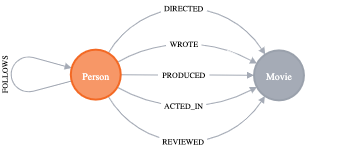

Alternatively, you may run the query directly with cy2py if you haven't done it through the browser:

In [5]:
%%cypher -u $neo4j_url -us $neo4j_user -pw $neo4j_password
// the following Cypher query is the same as above
// and is required for running the notebook
CREATE (TheMatrix:Movie {title:'The Matrix', released:1999, tagline:'Welcome to the Real World'})
CREATE (Keanu:Person {name:'Keanu Reeves', born:1964})
CREATE (Carrie:Person {name:'Carrie-Anne Moss', born:1967})
CREATE (Laurence:Person {name:'Laurence Fishburne', born:1961})
CREATE (Hugo:Person {name:'Hugo Weaving', born:1960})
CREATE (LillyW:Person {name:'Lilly Wachowski', born:1967})
CREATE (LanaW:Person {name:'Lana Wachowski', born:1965})
CREATE (JoelS:Person {name:'Joel Silver', born:1952})
CREATE
(Keanu)-[:ACTED_IN {roles:['Neo']}]->(TheMatrix),
(Carrie)-[:ACTED_IN {roles:['Trinity']}]->(TheMatrix),
(Laurence)-[:ACTED_IN {roles:['Morpheus']}]->(TheMatrix),
(Hugo)-[:ACTED_IN {roles:['Agent Smith']}]->(TheMatrix),
(LillyW)-[:DIRECTED]->(TheMatrix),
(LanaW)-[:DIRECTED]->(TheMatrix),
(JoelS)-[:PRODUCED]->(TheMatrix)

CREATE (Emil:Person {name:"Emil Eifrem", born:1978})
CREATE (Emil)-[:ACTED_IN {roles:["Emil"]}]->(TheMatrix)

CREATE (TheMatrixReloaded:Movie {title:'The Matrix Reloaded', released:2003, tagline:'Free your mind'})
CREATE
(Keanu)-[:ACTED_IN {roles:['Neo']}]->(TheMatrixReloaded),
(Carrie)-[:ACTED_IN {roles:['Trinity']}]->(TheMatrixReloaded),
(Laurence)-[:ACTED_IN {roles:['Morpheus']}]->(TheMatrixReloaded),
(Hugo)-[:ACTED_IN {roles:['Agent Smith']}]->(TheMatrixReloaded),
(LillyW)-[:DIRECTED]->(TheMatrixReloaded),
(LanaW)-[:DIRECTED]->(TheMatrixReloaded),
(JoelS)-[:PRODUCED]->(TheMatrixReloaded)

CREATE (TheMatrixRevolutions:Movie {title:'The Matrix Revolutions', released:2003, tagline:'Everything that has a beginning has an end'})
CREATE
(Keanu)-[:ACTED_IN {roles:['Neo']}]->(TheMatrixRevolutions),
(Carrie)-[:ACTED_IN {roles:['Trinity']}]->(TheMatrixRevolutions),
(Laurence)-[:ACTED_IN {roles:['Morpheus']}]->(TheMatrixRevolutions),
(Hugo)-[:ACTED_IN {roles:['Agent Smith']}]->(TheMatrixRevolutions),
(LillyW)-[:DIRECTED]->(TheMatrixRevolutions),
(LanaW)-[:DIRECTED]->(TheMatrixRevolutions),
(JoelS)-[:PRODUCED]->(TheMatrixRevolutions)

CREATE (TheDevilsAdvocate:Movie {title:"The Devil's Advocate", released:1997, tagline:'Evil has its winning ways'})
CREATE (Charlize:Person {name:'Charlize Theron', born:1975})
CREATE (Al:Person {name:'Al Pacino', born:1940})
CREATE (Taylor:Person {name:'Taylor Hackford', born:1944})
CREATE
(Keanu)-[:ACTED_IN {roles:['Kevin Lomax']}]->(TheDevilsAdvocate),
(Charlize)-[:ACTED_IN {roles:['Mary Ann Lomax']}]->(TheDevilsAdvocate),
(Al)-[:ACTED_IN {roles:['John Milton']}]->(TheDevilsAdvocate),
(Taylor)-[:DIRECTED]->(TheDevilsAdvocate)

CREATE (AFewGoodMen:Movie {title:"A Few Good Men", released:1992, tagline:"In the heart of the nation's capital, in a courthouse of the U.S. government, one man will stop at nothing to keep his honor, and one will stop at nothing to find the truth."})
CREATE (TomC:Person {name:'Tom Cruise', born:1962})
CREATE (JackN:Person {name:'Jack Nicholson', born:1937})
CREATE (DemiM:Person {name:'Demi Moore', born:1962})
CREATE (KevinB:Person {name:'Kevin Bacon', born:1958})
CREATE (KieferS:Person {name:'Kiefer Sutherland', born:1966})
CREATE (NoahW:Person {name:'Noah Wyle', born:1971})
CREATE (CubaG:Person {name:'Cuba Gooding Jr.', born:1968})
CREATE (KevinP:Person {name:'Kevin Pollak', born:1957})
CREATE (JTW:Person {name:'J.T. Walsh', born:1943})
CREATE (JamesM:Person {name:'James Marshall', born:1967})
CREATE (ChristopherG:Person {name:'Christopher Guest', born:1948})
CREATE (RobR:Person {name:'Rob Reiner', born:1947})
CREATE (AaronS:Person {name:'Aaron Sorkin', born:1961})
CREATE
(TomC)-[:ACTED_IN {roles:['Lt. Daniel Kaffee']}]->(AFewGoodMen),
(JackN)-[:ACTED_IN {roles:['Col. Nathan R. Jessup']}]->(AFewGoodMen),
(DemiM)-[:ACTED_IN {roles:['Lt. Cdr. JoAnne Galloway']}]->(AFewGoodMen),
(KevinB)-[:ACTED_IN {roles:['Capt. Jack Ross']}]->(AFewGoodMen),
(KieferS)-[:ACTED_IN {roles:['Lt. Jonathan Kendrick']}]->(AFewGoodMen),
(NoahW)-[:ACTED_IN {roles:['Cpl. Jeffrey Barnes']}]->(AFewGoodMen),
(CubaG)-[:ACTED_IN {roles:['Cpl. Carl Hammaker']}]->(AFewGoodMen),
(KevinP)-[:ACTED_IN {roles:['Lt. Sam Weinberg']}]->(AFewGoodMen),
(JTW)-[:ACTED_IN {roles:['Lt. Col. Matthew Andrew Markinson']}]->(AFewGoodMen),
(JamesM)-[:ACTED_IN {roles:['Pfc. Louden Downey']}]->(AFewGoodMen),
(ChristopherG)-[:ACTED_IN {roles:['Dr. Stone']}]->(AFewGoodMen),
(AaronS)-[:ACTED_IN {roles:['Man in Bar']}]->(AFewGoodMen),
(RobR)-[:DIRECTED]->(AFewGoodMen),
(AaronS)-[:WROTE]->(AFewGoodMen)

CREATE (TopGun:Movie {title:"Top Gun", released:1986, tagline:'I feel the need, the need for speed.'})
CREATE (KellyM:Person {name:'Kelly McGillis', born:1957})
CREATE (ValK:Person {name:'Val Kilmer', born:1959})
CREATE (AnthonyE:Person {name:'Anthony Edwards', born:1962})
CREATE (TomS:Person {name:'Tom Skerritt', born:1933})
CREATE (MegR:Person {name:'Meg Ryan', born:1961})
CREATE (TonyS:Person {name:'Tony Scott', born:1944})
CREATE (JimC:Person {name:'Jim Cash', born:1941})
CREATE
(TomC)-[:ACTED_IN {roles:['Maverick']}]->(TopGun),
(KellyM)-[:ACTED_IN {roles:['Charlie']}]->(TopGun),
(ValK)-[:ACTED_IN {roles:['Iceman']}]->(TopGun),
(AnthonyE)-[:ACTED_IN {roles:['Goose']}]->(TopGun),
(TomS)-[:ACTED_IN {roles:['Viper']}]->(TopGun),
(MegR)-[:ACTED_IN {roles:['Carole']}]->(TopGun),
(TonyS)-[:DIRECTED]->(TopGun),
(JimC)-[:WROTE]->(TopGun)

CREATE (JerryMaguire:Movie {title:'Jerry Maguire', released:2000, tagline:'The rest of his life begins now.'})
CREATE (ReneeZ:Person {name:'Renee Zellweger', born:1969})
CREATE (KellyP:Person {name:'Kelly Preston', born:1962})
CREATE (JerryO:Person {name:"Jerry O'Connell", born:1974})
CREATE (JayM:Person {name:'Jay Mohr', born:1970})
CREATE (BonnieH:Person {name:'Bonnie Hunt', born:1961})
CREATE (ReginaK:Person {name:'Regina King', born:1971})
CREATE (JonathanL:Person {name:'Jonathan Lipnicki', born:1996})
CREATE (CameronC:Person {name:'Cameron Crowe', born:1957})
CREATE
(TomC)-[:ACTED_IN {roles:['Jerry Maguire']}]->(JerryMaguire),
(CubaG)-[:ACTED_IN {roles:['Rod Tidwell']}]->(JerryMaguire),
(ReneeZ)-[:ACTED_IN {roles:['Dorothy Boyd']}]->(JerryMaguire),
(KellyP)-[:ACTED_IN {roles:['Avery Bishop']}]->(JerryMaguire),
(JerryO)-[:ACTED_IN {roles:['Frank Cushman']}]->(JerryMaguire),
(JayM)-[:ACTED_IN {roles:['Bob Sugar']}]->(JerryMaguire),
(BonnieH)-[:ACTED_IN {roles:['Laurel Boyd']}]->(JerryMaguire),
(ReginaK)-[:ACTED_IN {roles:['Marcee Tidwell']}]->(JerryMaguire),
(JonathanL)-[:ACTED_IN {roles:['Ray Boyd']}]->(JerryMaguire),
(CameronC)-[:DIRECTED]->(JerryMaguire),
(CameronC)-[:PRODUCED]->(JerryMaguire),
(CameronC)-[:WROTE]->(JerryMaguire)

CREATE (StandByMe:Movie {title:"Stand By Me", released:1986, tagline:"For some, it's the last real taste of innocence, and the first real taste of life. But for everyone, it's the time that memories are made of."})
CREATE (RiverP:Person {name:'River Phoenix', born:1970})
CREATE (CoreyF:Person {name:'Corey Feldman', born:1971})
CREATE (WilW:Person {name:'Wil Wheaton', born:1972})
CREATE (JohnC:Person {name:'John Cusack', born:1966})
CREATE (MarshallB:Person {name:'Marshall Bell', born:1942})
CREATE
(WilW)-[:ACTED_IN {roles:['Gordie Lachance']}]->(StandByMe),
(RiverP)-[:ACTED_IN {roles:['Chris Chambers']}]->(StandByMe),
(JerryO)-[:ACTED_IN {roles:['Vern Tessio']}]->(StandByMe),
(CoreyF)-[:ACTED_IN {roles:['Teddy Duchamp']}]->(StandByMe),
(JohnC)-[:ACTED_IN {roles:['Denny Lachance']}]->(StandByMe),
(KieferS)-[:ACTED_IN {roles:['Ace Merrill']}]->(StandByMe),
(MarshallB)-[:ACTED_IN {roles:['Mr. Lachance']}]->(StandByMe),
(RobR)-[:DIRECTED]->(StandByMe)

CREATE (AsGoodAsItGets:Movie {title:'As Good as It Gets', released:1997, tagline:'A comedy from the heart that goes for the throat.'})
CREATE (HelenH:Person {name:'Helen Hunt', born:1963})
CREATE (GregK:Person {name:'Greg Kinnear', born:1963})
CREATE (JamesB:Person {name:'James L. Brooks', born:1940})
CREATE
(JackN)-[:ACTED_IN {roles:['Melvin Udall']}]->(AsGoodAsItGets),
(HelenH)-[:ACTED_IN {roles:['Carol Connelly']}]->(AsGoodAsItGets),
(GregK)-[:ACTED_IN {roles:['Simon Bishop']}]->(AsGoodAsItGets),
(CubaG)-[:ACTED_IN {roles:['Frank Sachs']}]->(AsGoodAsItGets),
(JamesB)-[:DIRECTED]->(AsGoodAsItGets)

CREATE (WhatDreamsMayCome:Movie {title:'What Dreams May Come', released:1998, tagline:'After life there is more. The end is just the beginning.'})
CREATE (AnnabellaS:Person {name:'Annabella Sciorra', born:1960})
CREATE (MaxS:Person {name:'Max von Sydow', born:1929})
CREATE (WernerH:Person {name:'Werner Herzog', born:1942})
CREATE (Robin:Person {name:'Robin Williams', born:1951})
CREATE (VincentW:Person {name:'Vincent Ward', born:1956})
CREATE
(Robin)-[:ACTED_IN {roles:['Chris Nielsen']}]->(WhatDreamsMayCome),
(CubaG)-[:ACTED_IN {roles:['Albert Lewis']}]->(WhatDreamsMayCome),
(AnnabellaS)-[:ACTED_IN {roles:['Annie Collins-Nielsen']}]->(WhatDreamsMayCome),
(MaxS)-[:ACTED_IN {roles:['The Tracker']}]->(WhatDreamsMayCome),
(WernerH)-[:ACTED_IN {roles:['The Face']}]->(WhatDreamsMayCome),
(VincentW)-[:DIRECTED]->(WhatDreamsMayCome)

CREATE (SnowFallingonCedars:Movie {title:'Snow Falling on Cedars', released:1999, tagline:'First loves last. Forever.'})
CREATE (EthanH:Person {name:'Ethan Hawke', born:1970})
CREATE (RickY:Person {name:'Rick Yune', born:1971})
CREATE (JamesC:Person {name:'James Cromwell', born:1940})
CREATE (ScottH:Person {name:'Scott Hicks', born:1953})
CREATE
(EthanH)-[:ACTED_IN {roles:['Ishmael Chambers']}]->(SnowFallingonCedars),
(RickY)-[:ACTED_IN {roles:['Kazuo Miyamoto']}]->(SnowFallingonCedars),
(MaxS)-[:ACTED_IN {roles:['Nels Gudmundsson']}]->(SnowFallingonCedars),
(JamesC)-[:ACTED_IN {roles:['Judge Fielding']}]->(SnowFallingonCedars),
(ScottH)-[:DIRECTED]->(SnowFallingonCedars)

CREATE (YouveGotMail:Movie {title:"You've Got Mail", released:1998, tagline:'At odds in life... in love on-line.'})
CREATE (ParkerP:Person {name:'Parker Posey', born:1968})
CREATE (DaveC:Person {name:'Dave Chappelle', born:1973})
CREATE (SteveZ:Person {name:'Steve Zahn', born:1967})
CREATE (TomH:Person {name:'Tom Hanks', born:1956})
CREATE (NoraE:Person {name:'Nora Ephron', born:1941})
CREATE
(TomH)-[:ACTED_IN {roles:['Joe Fox']}]->(YouveGotMail),
(MegR)-[:ACTED_IN {roles:['Kathleen Kelly']}]->(YouveGotMail),
(GregK)-[:ACTED_IN {roles:['Frank Navasky']}]->(YouveGotMail),
(ParkerP)-[:ACTED_IN {roles:['Patricia Eden']}]->(YouveGotMail),
(DaveC)-[:ACTED_IN {roles:['Kevin Jackson']}]->(YouveGotMail),
(SteveZ)-[:ACTED_IN {roles:['George Pappas']}]->(YouveGotMail),
(NoraE)-[:DIRECTED]->(YouveGotMail)

CREATE (SleeplessInSeattle:Movie {title:'Sleepless in Seattle', released:1993, tagline:'What if someone you never met, someone you never saw, someone you never knew was the only someone for you?'})
CREATE (RitaW:Person {name:'Rita Wilson', born:1956})
CREATE (BillPull:Person {name:'Bill Pullman', born:1953})
CREATE (VictorG:Person {name:'Victor Garber', born:1949})
CREATE (RosieO:Person {name:"Rosie O'Donnell", born:1962})
CREATE
(TomH)-[:ACTED_IN {roles:['Sam Baldwin']}]->(SleeplessInSeattle),
(MegR)-[:ACTED_IN {roles:['Annie Reed']}]->(SleeplessInSeattle),
(RitaW)-[:ACTED_IN {roles:['Suzy']}]->(SleeplessInSeattle),
(BillPull)-[:ACTED_IN {roles:['Walter']}]->(SleeplessInSeattle),
(VictorG)-[:ACTED_IN {roles:['Greg']}]->(SleeplessInSeattle),
(RosieO)-[:ACTED_IN {roles:['Becky']}]->(SleeplessInSeattle),
(NoraE)-[:DIRECTED]->(SleeplessInSeattle)

CREATE (JoeVersustheVolcano:Movie {title:'Joe Versus the Volcano', released:1990, tagline:'A story of love, lava and burning desire.'})
CREATE (JohnS:Person {name:'John Patrick Stanley', born:1950})
CREATE (Nathan:Person {name:'Nathan Lane', born:1956})
CREATE
(TomH)-[:ACTED_IN {roles:['Joe Banks']}]->(JoeVersustheVolcano),
(MegR)-[:ACTED_IN {roles:['DeDe', 'Angelica Graynamore', 'Patricia Graynamore']}]->(JoeVersustheVolcano),
(Nathan)-[:ACTED_IN {roles:['Baw']}]->(JoeVersustheVolcano),
(JohnS)-[:DIRECTED]->(JoeVersustheVolcano)

CREATE (WhenHarryMetSally:Movie {title:'When Harry Met Sally', released:1998, tagline:'Can two friends sleep together and still love each other in the morning?'})
CREATE (BillyC:Person {name:'Billy Crystal', born:1948})
CREATE (CarrieF:Person {name:'Carrie Fisher', born:1956})
CREATE (BrunoK:Person {name:'Bruno Kirby', born:1949})
CREATE
(BillyC)-[:ACTED_IN {roles:['Harry Burns']}]->(WhenHarryMetSally),
(MegR)-[:ACTED_IN {roles:['Sally Albright']}]->(WhenHarryMetSally),
(CarrieF)-[:ACTED_IN {roles:['Marie']}]->(WhenHarryMetSally),
(BrunoK)-[:ACTED_IN {roles:['Jess']}]->(WhenHarryMetSally),
(RobR)-[:DIRECTED]->(WhenHarryMetSally),
(RobR)-[:PRODUCED]->(WhenHarryMetSally),
(NoraE)-[:PRODUCED]->(WhenHarryMetSally),
(NoraE)-[:WROTE]->(WhenHarryMetSally)

CREATE (ThatThingYouDo:Movie {title:'That Thing You Do', released:1996, tagline:'In every life there comes a time when that thing you dream becomes that thing you do'})
CREATE (LivT:Person {name:'Liv Tyler', born:1977})
CREATE
(TomH)-[:ACTED_IN {roles:['Mr. White']}]->(ThatThingYouDo),
(LivT)-[:ACTED_IN {roles:['Faye Dolan']}]->(ThatThingYouDo),
(Charlize)-[:ACTED_IN {roles:['Tina']}]->(ThatThingYouDo),
(TomH)-[:DIRECTED]->(ThatThingYouDo)

CREATE (TheReplacements:Movie {title:'The Replacements', released:2000, tagline:'Pain heals, Chicks dig scars... Glory lasts forever'})
CREATE (Brooke:Person {name:'Brooke Langton', born:1970})
CREATE (Gene:Person {name:'Gene Hackman', born:1930})
CREATE (Orlando:Person {name:'Orlando Jones', born:1968})
CREATE (Howard:Person {name:'Howard Deutch', born:1950})
CREATE
(Keanu)-[:ACTED_IN {roles:['Shane Falco']}]->(TheReplacements),
(Brooke)-[:ACTED_IN {roles:['Annabelle Farrell']}]->(TheReplacements),
(Gene)-[:ACTED_IN {roles:['Jimmy McGinty']}]->(TheReplacements),
(Orlando)-[:ACTED_IN {roles:['Clifford Franklin']}]->(TheReplacements),
(Howard)-[:DIRECTED]->(TheReplacements)

CREATE (RescueDawn:Movie {title:'RescueDawn', released:2006, tagline:"Based on the extraordinary true story of one man's fight for freedom"})
CREATE (ChristianB:Person {name:'Christian Bale', born:1974})
CREATE (ZachG:Person {name:'Zach Grenier', born:1954})
CREATE
(MarshallB)-[:ACTED_IN {roles:['Admiral']}]->(RescueDawn),
(ChristianB)-[:ACTED_IN {roles:['Dieter Dengler']}]->(RescueDawn),
(ZachG)-[:ACTED_IN {roles:['Squad Leader']}]->(RescueDawn),
(SteveZ)-[:ACTED_IN {roles:['Duane']}]->(RescueDawn),
(WernerH)-[:DIRECTED]->(RescueDawn)

CREATE (TheBirdcage:Movie {title:'The Birdcage', released:1996, tagline:'Come as you are'})
CREATE (MikeN:Person {name:'Mike Nichols', born:1931})
CREATE
(Robin)-[:ACTED_IN {roles:['Armand Goldman']}]->(TheBirdcage),
(Nathan)-[:ACTED_IN {roles:['Albert Goldman']}]->(TheBirdcage),
(Gene)-[:ACTED_IN {roles:['Sen. Kevin Keeley']}]->(TheBirdcage),
(MikeN)-[:DIRECTED]->(TheBirdcage)

CREATE (Unforgiven:Movie {title:'Unforgiven', released:1992, tagline:"It's a hell of a thing, killing a man"})
CREATE (RichardH:Person {name:'Richard Harris', born:1930})
CREATE (ClintE:Person {name:'Clint Eastwood', born:1930})
CREATE
(RichardH)-[:ACTED_IN {roles:['English Bob']}]->(Unforgiven),
(ClintE)-[:ACTED_IN {roles:['Bill Munny']}]->(Unforgiven),
(Gene)-[:ACTED_IN {roles:['Little Bill Daggett']}]->(Unforgiven),
(ClintE)-[:DIRECTED]->(Unforgiven)

CREATE (JohnnyMnemonic:Movie {title:'Johnny Mnemonic', released:1995, tagline:'The hottest data on earth. In the coolest head in town'})
CREATE (Takeshi:Person {name:'Takeshi Kitano', born:1947})
CREATE (Dina:Person {name:'Dina Meyer', born:1968})
CREATE (IceT:Person {name:'Ice-T', born:1958})
CREATE (RobertL:Person {name:'Robert Longo', born:1953})
CREATE
(Keanu)-[:ACTED_IN {roles:['Johnny Mnemonic']}]->(JohnnyMnemonic),
(Takeshi)-[:ACTED_IN {roles:['Takahashi']}]->(JohnnyMnemonic),
(Dina)-[:ACTED_IN {roles:['Jane']}]->(JohnnyMnemonic),
(IceT)-[:ACTED_IN {roles:['J-Bone']}]->(JohnnyMnemonic),
(RobertL)-[:DIRECTED]->(JohnnyMnemonic)

CREATE (CloudAtlas:Movie {title:'Cloud Atlas', released:2012, tagline:'Everything is connected'})
CREATE (HalleB:Person {name:'Halle Berry', born:1966})
CREATE (JimB:Person {name:'Jim Broadbent', born:1949})
CREATE (TomT:Person {name:'Tom Tykwer', born:1965})
CREATE (DavidMitchell:Person {name:'David Mitchell', born:1969})
CREATE (StefanArndt:Person {name:'Stefan Arndt', born:1961})
CREATE
(TomH)-[:ACTED_IN {roles:['Zachry', 'Dr. Henry Goose', 'Isaac Sachs', 'Dermot Hoggins']}]->(CloudAtlas),
(Hugo)-[:ACTED_IN {roles:['Bill Smoke', 'Haskell Moore', 'Tadeusz Kesselring', 'Nurse Noakes', 'Boardman Mephi', 'Old Georgie']}]->(CloudAtlas),
(HalleB)-[:ACTED_IN {roles:['Luisa Rey', 'Jocasta Ayrs', 'Ovid', 'Meronym']}]->(CloudAtlas),
(JimB)-[:ACTED_IN {roles:['Vyvyan Ayrs', 'Captain Molyneux', 'Timothy Cavendish']}]->(CloudAtlas),
(TomT)-[:DIRECTED]->(CloudAtlas),
(LillyW)-[:DIRECTED]->(CloudAtlas),
(LanaW)-[:DIRECTED]->(CloudAtlas),
(DavidMitchell)-[:WROTE]->(CloudAtlas),
(StefanArndt)-[:PRODUCED]->(CloudAtlas)

CREATE (TheDaVinciCode:Movie {title:'The Da Vinci Code', released:2006, tagline:'Break The Codes'})
CREATE (IanM:Person {name:'Ian McKellen', born:1939})
CREATE (AudreyT:Person {name:'Audrey Tautou', born:1976})
CREATE (PaulB:Person {name:'Paul Bettany', born:1971})
CREATE (RonH:Person {name:'Ron Howard', born:1954})
CREATE
(TomH)-[:ACTED_IN {roles:['Dr. Robert Langdon']}]->(TheDaVinciCode),
(IanM)-[:ACTED_IN {roles:['Sir Leight Teabing']}]->(TheDaVinciCode),
(AudreyT)-[:ACTED_IN {roles:['Sophie Neveu']}]->(TheDaVinciCode),
(PaulB)-[:ACTED_IN {roles:['Silas']}]->(TheDaVinciCode),
(RonH)-[:DIRECTED]->(TheDaVinciCode)

CREATE (VforVendetta:Movie {title:'V for Vendetta', released:2006, tagline:'Freedom! Forever!'})
CREATE (NatalieP:Person {name:'Natalie Portman', born:1981})
CREATE (StephenR:Person {name:'Stephen Rea', born:1946})
CREATE (JohnH:Person {name:'John Hurt', born:1940})
CREATE (BenM:Person {name: 'Ben Miles', born:1967})
CREATE
(Hugo)-[:ACTED_IN {roles:['V']}]->(VforVendetta),
(NatalieP)-[:ACTED_IN {roles:['Evey Hammond']}]->(VforVendetta),
(StephenR)-[:ACTED_IN {roles:['Eric Finch']}]->(VforVendetta),
(JohnH)-[:ACTED_IN {roles:['High Chancellor Adam Sutler']}]->(VforVendetta),
(BenM)-[:ACTED_IN {roles:['Dascomb']}]->(VforVendetta),
(JamesM)-[:DIRECTED]->(VforVendetta),
(LillyW)-[:PRODUCED]->(VforVendetta),
(LanaW)-[:PRODUCED]->(VforVendetta),
(JoelS)-[:PRODUCED]->(VforVendetta),
(LillyW)-[:WROTE]->(VforVendetta),
(LanaW)-[:WROTE]->(VforVendetta)

CREATE (SpeedRacer:Movie {title:'Speed Racer', released:2008, tagline:'Speed has no limits'})
CREATE (EmileH:Person {name:'Emile Hirsch', born:1985})
CREATE (JohnG:Person {name:'John Goodman', born:1960})
CREATE (SusanS:Person {name:'Susan Sarandon', born:1946})
CREATE (MatthewF:Person {name:'Matthew Fox', born:1966})
CREATE (ChristinaR:Person {name:'Christina Ricci', born:1980})
CREATE (Rain:Person {name:'Rain', born:1982})
CREATE
(EmileH)-[:ACTED_IN {roles:['Speed Racer']}]->(SpeedRacer),
(JohnG)-[:ACTED_IN {roles:['Pops']}]->(SpeedRacer),
(SusanS)-[:ACTED_IN {roles:['Mom']}]->(SpeedRacer),
(MatthewF)-[:ACTED_IN {roles:['Racer X']}]->(SpeedRacer),
(ChristinaR)-[:ACTED_IN {roles:['Trixie']}]->(SpeedRacer),
(Rain)-[:ACTED_IN {roles:['Taejo Togokahn']}]->(SpeedRacer),
(BenM)-[:ACTED_IN {roles:['Cass Jones']}]->(SpeedRacer),
(LillyW)-[:DIRECTED]->(SpeedRacer),
(LanaW)-[:DIRECTED]->(SpeedRacer),
(LillyW)-[:WROTE]->(SpeedRacer),
(LanaW)-[:WROTE]->(SpeedRacer),
(JoelS)-[:PRODUCED]->(SpeedRacer)

CREATE (NinjaAssassin:Movie {title:'Ninja Assassin', released:2009, tagline:'Prepare to enter a secret world of assassins'})
CREATE (NaomieH:Person {name:'Naomie Harris'})
CREATE
(Rain)-[:ACTED_IN {roles:['Raizo']}]->(NinjaAssassin),
(NaomieH)-[:ACTED_IN {roles:['Mika Coretti']}]->(NinjaAssassin),
(RickY)-[:ACTED_IN {roles:['Takeshi']}]->(NinjaAssassin),
(BenM)-[:ACTED_IN {roles:['Ryan Maslow']}]->(NinjaAssassin),
(JamesM)-[:DIRECTED]->(NinjaAssassin),
(LillyW)-[:PRODUCED]->(NinjaAssassin),
(LanaW)-[:PRODUCED]->(NinjaAssassin),
(JoelS)-[:PRODUCED]->(NinjaAssassin)

CREATE (TheGreenMile:Movie {title:'The Green Mile', released:1999, tagline:"Walk a mile you'll never forget."})
CREATE (MichaelD:Person {name:'Michael Clarke Duncan', born:1957})
CREATE (DavidM:Person {name:'David Morse', born:1953})
CREATE (SamR:Person {name:'Sam Rockwell', born:1968})
CREATE (GaryS:Person {name:'Gary Sinise', born:1955})
CREATE (PatriciaC:Person {name:'Patricia Clarkson', born:1959})
CREATE (FrankD:Person {name:'Frank Darabont', born:1959})
CREATE
(TomH)-[:ACTED_IN {roles:['Paul Edgecomb']}]->(TheGreenMile),
(MichaelD)-[:ACTED_IN {roles:['John Coffey']}]->(TheGreenMile),
(DavidM)-[:ACTED_IN {roles:['Brutus "Brutal" Howell']}]->(TheGreenMile),
(BonnieH)-[:ACTED_IN {roles:['Jan Edgecomb']}]->(TheGreenMile),
(JamesC)-[:ACTED_IN {roles:['Warden Hal Moores']}]->(TheGreenMile),
(SamR)-[:ACTED_IN {roles:['"Wild Bill" Wharton']}]->(TheGreenMile),
(GaryS)-[:ACTED_IN {roles:['Burt Hammersmith']}]->(TheGreenMile),
(PatriciaC)-[:ACTED_IN {roles:['Melinda Moores']}]->(TheGreenMile),
(FrankD)-[:DIRECTED]->(TheGreenMile)

CREATE (FrostNixon:Movie {title:'Frost/Nixon', released:2008, tagline:'400 million people were waiting for the truth.'})
CREATE (FrankL:Person {name:'Frank Langella', born:1938})
CREATE (MichaelS:Person {name:'Michael Sheen', born:1969})
CREATE (OliverP:Person {name:'Oliver Platt', born:1960})
CREATE
(FrankL)-[:ACTED_IN {roles:['Richard Nixon']}]->(FrostNixon),
(MichaelS)-[:ACTED_IN {roles:['David Frost']}]->(FrostNixon),
(KevinB)-[:ACTED_IN {roles:['Jack Brennan']}]->(FrostNixon),
(OliverP)-[:ACTED_IN {roles:['Bob Zelnick']}]->(FrostNixon),
(SamR)-[:ACTED_IN {roles:['James Reston, Jr.']}]->(FrostNixon),
(RonH)-[:DIRECTED]->(FrostNixon)

CREATE (Hoffa:Movie {title:'Hoffa', released:1992, tagline:"He didn't want law. He wanted justice."})
CREATE (DannyD:Person {name:'Danny DeVito', born:1944})
CREATE (JohnR:Person {name:'John C. Reilly', born:1965})
CREATE
(JackN)-[:ACTED_IN {roles:['Hoffa']}]->(Hoffa),
(DannyD)-[:ACTED_IN {roles:['Robert "Bobby" Ciaro']}]->(Hoffa),
(JTW)-[:ACTED_IN {roles:['Frank Fitzsimmons']}]->(Hoffa),
(JohnR)-[:ACTED_IN {roles:['Peter "Pete" Connelly']}]->(Hoffa),
(DannyD)-[:DIRECTED]->(Hoffa)

CREATE (Apollo13:Movie {title:'Apollo 13', released:1995, tagline:'Houston, we have a problem.'})
CREATE (EdH:Person {name:'Ed Harris', born:1950})
CREATE (BillPax:Person {name:'Bill Paxton', born:1955})
CREATE
(TomH)-[:ACTED_IN {roles:['Jim Lovell']}]->(Apollo13),
(KevinB)-[:ACTED_IN {roles:['Jack Swigert']}]->(Apollo13),
(EdH)-[:ACTED_IN {roles:['Gene Kranz']}]->(Apollo13),
(BillPax)-[:ACTED_IN {roles:['Fred Haise']}]->(Apollo13),
(GaryS)-[:ACTED_IN {roles:['Ken Mattingly']}]->(Apollo13),
(RonH)-[:DIRECTED]->(Apollo13)

CREATE (Twister:Movie {title:'Twister', released:1996, tagline:"Don't Breathe. Don't Look Back."})
CREATE (PhilipH:Person {name:'Philip Seymour Hoffman', born:1967})
CREATE (JanB:Person {name:'Jan de Bont', born:1943})
CREATE
(BillPax)-[:ACTED_IN {roles:['Bill Harding']}]->(Twister),
(HelenH)-[:ACTED_IN {roles:['Dr. Jo Harding']}]->(Twister),
(ZachG)-[:ACTED_IN {roles:['Eddie']}]->(Twister),
(PhilipH)-[:ACTED_IN {roles:['Dustin "Dusty" Davis']}]->(Twister),
(JanB)-[:DIRECTED]->(Twister)

CREATE (CastAway:Movie {title:'Cast Away', released:2000, tagline:'At the edge of the world, his journey begins.'})
CREATE (RobertZ:Person {name:'Robert Zemeckis', born:1951})
CREATE
(TomH)-[:ACTED_IN {roles:['Chuck Noland']}]->(CastAway),
(HelenH)-[:ACTED_IN {roles:['Kelly Frears']}]->(CastAway),
(RobertZ)-[:DIRECTED]->(CastAway)

CREATE (OneFlewOvertheCuckoosNest:Movie {title:"One Flew Over the Cuckoo's Nest", released:1975, tagline:"If he's crazy, what does that make you?"})
CREATE (MilosF:Person {name:'Milos Forman', born:1932})
CREATE
(JackN)-[:ACTED_IN {roles:['Randle McMurphy']}]->(OneFlewOvertheCuckoosNest),
(DannyD)-[:ACTED_IN {roles:['Martini']}]->(OneFlewOvertheCuckoosNest),
(MilosF)-[:DIRECTED]->(OneFlewOvertheCuckoosNest)

CREATE (SomethingsGottaGive:Movie {title:"Something's Gotta Give", released:2003})
CREATE (DianeK:Person {name:'Diane Keaton', born:1946})
CREATE (NancyM:Person {name:'Nancy Meyers', born:1949})
CREATE
(JackN)-[:ACTED_IN {roles:['Harry Sanborn']}]->(SomethingsGottaGive),
(DianeK)-[:ACTED_IN {roles:['Erica Barry']}]->(SomethingsGottaGive),
(Keanu)-[:ACTED_IN {roles:['Julian Mercer']}]->(SomethingsGottaGive),
(NancyM)-[:DIRECTED]->(SomethingsGottaGive),
(NancyM)-[:PRODUCED]->(SomethingsGottaGive),
(NancyM)-[:WROTE]->(SomethingsGottaGive)

CREATE (BicentennialMan:Movie {title:'Bicentennial Man', released:1999, tagline:"One robot's 200 year journey to become an ordinary man."})
CREATE (ChrisC:Person {name:'Chris Columbus', born:1958})
CREATE
(Robin)-[:ACTED_IN {roles:['Andrew Marin']}]->(BicentennialMan),
(OliverP)-[:ACTED_IN {roles:['Rupert Burns']}]->(BicentennialMan),
(ChrisC)-[:DIRECTED]->(BicentennialMan)

CREATE (CharlieWilsonsWar:Movie {title:"Charlie Wilson's War", released:2007, tagline:"A stiff drink. A little mascara. A lot of nerve. Who said they couldn't bring down the Soviet empire."})
CREATE (JuliaR:Person {name:'Julia Roberts', born:1967})
CREATE
(TomH)-[:ACTED_IN {roles:['Rep. Charlie Wilson']}]->(CharlieWilsonsWar),
(JuliaR)-[:ACTED_IN {roles:['Joanne Herring']}]->(CharlieWilsonsWar),
(PhilipH)-[:ACTED_IN {roles:['Gust Avrakotos']}]->(CharlieWilsonsWar),
(MikeN)-[:DIRECTED]->(CharlieWilsonsWar)

CREATE (ThePolarExpress:Movie {title:'The Polar Express', released:2004, tagline:'This Holiday Season... Believe'})
CREATE
(TomH)-[:ACTED_IN {roles:['Hero Boy', 'Father', 'Conductor', 'Hobo', 'Scrooge', 'Santa Claus']}]->(ThePolarExpress),
(RobertZ)-[:DIRECTED]->(ThePolarExpress)

CREATE (ALeagueofTheirOwn:Movie {title:'A League of Their Own', released:1992, tagline:'Once in a lifetime you get a chance to do something different.'})
CREATE (Madonna:Person {name:'Madonna', born:1954})
CREATE (GeenaD:Person {name:'Geena Davis', born:1956})
CREATE (LoriP:Person {name:'Lori Petty', born:1963})
CREATE (PennyM:Person {name:'Penny Marshall', born:1943})
CREATE
(TomH)-[:ACTED_IN {roles:['Jimmy Dugan']}]->(ALeagueofTheirOwn),
(GeenaD)-[:ACTED_IN {roles:['Dottie Hinson']}]->(ALeagueofTheirOwn),
(LoriP)-[:ACTED_IN {roles:['Kit Keller']}]->(ALeagueofTheirOwn),
(RosieO)-[:ACTED_IN {roles:['Doris Murphy']}]->(ALeagueofTheirOwn),
(Madonna)-[:ACTED_IN {roles:['"All the Way" Mae Mordabito']}]->(ALeagueofTheirOwn),
(BillPax)-[:ACTED_IN {roles:['Bob Hinson']}]->(ALeagueofTheirOwn),
(PennyM)-[:DIRECTED]->(ALeagueofTheirOwn)

CREATE (PaulBlythe:Person {name:'Paul Blythe'})
CREATE (AngelaScope:Person {name:'Angela Scope'})
CREATE (JessicaThompson:Person {name:'Jessica Thompson'})
CREATE (JamesThompson:Person {name:'James Thompson'})

CREATE
(JamesThompson)-[:FOLLOWS]->(JessicaThompson),
(AngelaScope)-[:FOLLOWS]->(JessicaThompson),
(PaulBlythe)-[:FOLLOWS]->(AngelaScope)

CREATE
(JessicaThompson)-[:REVIEWED {summary:'An amazing journey', rating:95}]->(CloudAtlas),
(JessicaThompson)-[:REVIEWED {summary:'Silly, but fun', rating:65}]->(TheReplacements),
(JamesThompson)-[:REVIEWED {summary:'The coolest football movie ever', rating:100}]->(TheReplacements),
(AngelaScope)-[:REVIEWED {summary:'Pretty funny at times', rating:62}]->(TheReplacements),
(JessicaThompson)-[:REVIEWED {summary:'Dark, but compelling', rating:85}]->(Unforgiven),
(JessicaThompson)-[:REVIEWED {summary:"Slapstick redeemed only by the Robin Williams and Gene Hackman's stellar performances", rating:45}]->(TheBirdcage),
(JessicaThompson)-[:REVIEWED {summary:'A solid romp', rating:68}]->(TheDaVinciCode),
(JamesThompson)-[:REVIEWED {summary:'Fun, but a little far fetched', rating:65}]->(TheDaVinciCode),
(JessicaThompson)-[:REVIEWED {summary:'You had me at Jerry', rating:92}]->(JerryMaguire)

WITH TomH as a
MATCH (a)-[:ACTED_IN]->(m)<-[:DIRECTED]-(d) RETURN a,m,d LIMIT 10;

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'padding': 0, 'nodeSpacing': 10, 'edgeLengthVal': 10, 'anim…

You can test the cy2py integration with your database by running the cell below, which queries the database and returns dummy data

In [6]:
my_simple_df = %cypher -a basic -u $neo4j_url -us $neo4j_user -pw $neo4j_pwd RETURN 1 AS foo, 'bar' AS bar
my_simple_df

,foo,bar
0,1,bar


As you can see the model is exactely how we expect!

In [7]:
# this step is MANDATORY for the validation code following exercises 
from neo4j import GraphDatabase
neo4j_driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_user, neo4j_password))

# Read data from Neo4j into Spark


The query above generates the following graph model:



## Read nodes via `labels` option

In [8]:
movies_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('labels', ':Movie')
            .load())

25/03/04 15:27:22 WARN SchemaService: Switching to query schema resolution


### Schema description

In [9]:
movies_df.printSchema()

root
 |-- <id>: long (nullable = false)
 |-- <labels>: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- released: long (nullable = true)



The `movies_df` contains a set of fields, the first two (generally) are always:

* `<id>` which represents the internal Neo4j id
* `<labels>` which represents the list of labels attached to the node

All other properties are taken from the node via schema resolution by using APOC or Cypher queries

In [10]:
movies_df

<id>,<labels>,title,tagline,released
0,[Movie],The Matrix,Welcome to the Re...,1999
9,[Movie],The Matrix Reloaded,Free your mind,2003
10,[Movie],The Matrix Revolu...,Everything that h...,2003
11,[Movie],The Devil's Advocate,Evil has its winn...,1997
15,[Movie],A Few Good Men,In the heart of t...,1992
29,[Movie],Top Gun,"I feel the need, ...",1986
37,[Movie],Jerry Maguire,The rest of his l...,2000
46,[Movie],Stand By Me,"For some, it's th...",1986
52,[Movie],As Good as It Gets,A comedy from the...,1997
56,[Movie],What Dreams May Come,After life there ...,1998


### Exercise

Read all the `Person` nodes store them into a Python variable called `person_df` and then verify the results

In [11]:
person_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('labels', ':Person')
            .load())

25/03/04 15:27:34 WARN SchemaService: Switching to query schema resolution


<details>
<summary>
Show a possible solution
</summary>

```python
person_df = (spark.read
  .format('org.neo4j.spark.DataSource')
  .option('labels', ':Person')
  .load())
```

</details>



In [12]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 created the person_df
"""

assert person_df.count() == 133
assert person_df.schema.fieldNames() == ['<id>', '<labels>', 'name', 'born']
assert person_df.collect()[0]["<labels>"] == ['Person']
print("All assertion are successfuly satisfied. Congrats you created your first DataFrame")

AssertionError: 

## Read relationships via `relationship` option

There are two way to transform relationships into DataFrame

* having all the node and relationship data flattened into the DataFrame
* having all the node properties in maps and the relationship data as columns

### DataFrame with flattened data

In [13]:
actedin_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('relationship', 'ACTED_IN')
            .option('relationship.source.labels', ':Person')
            .option('relationship.target.labels', ':Movie')
            .load())

25/03/04 15:27:53 WARN SchemaService: Switching to query schema resolution
25/03/04 15:27:53 WARN SchemaService: Switching to query schema resolution
25/03/04 15:27:53 WARN SchemaService: Switching to query schema resolution


### Schema description

In [14]:
actedin_df.printSchema()

root
 |-- <rel.id>: long (nullable = false)
 |-- <rel.type>: string (nullable = false)
 |-- <source.id>: long (nullable = false)
 |-- <source.labels>: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- source.name: string (nullable = true)
 |-- source.born: long (nullable = true)
 |-- <target.id>: long (nullable = false)
 |-- <target.labels>: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- target.title: string (nullable = true)
 |-- target.tagline: string (nullable = true)
 |-- target.released: long (nullable = true)
 |-- rel.roles: array (nullable = true)
 |    |-- element: string (containsNull = true)



The `movies_df` contains a set of fields, the first two (generally) are always:

* `<rel.id>` which represents the internal Neo4j relationship id
* `<rel.type>` which represents the relationship type
* `<source/target.id>` which represents the internal Neo4j node id
* `<source/target.labels>` which represents the list of labels attached to the node
* `rel.*` which represents the properties attached to the relationship
* `source/target.*` which represents the properties attached to the node

All other properties are taken from the node via schema resolution by using APOC or Cypher queries

In [15]:
actedin_df

<rel.id>,<rel.type>,<source.id>,<source.labels>,source.name,source.born,<target.id>,<target.labels>,target.title,target.tagline,target.released,rel.roles
7,ACTED_IN,8,[Person],Emil Eifrem,1978,0,[Movie],The Matrix,Welcome to the Re...,1999,[Emil]
3,ACTED_IN,4,[Person],Hugo Weaving,1960,0,[Movie],The Matrix,Welcome to the Re...,1999,[Agent Smith]
2,ACTED_IN,3,[Person],Laurence Fishburne,1961,0,[Movie],The Matrix,Welcome to the Re...,1999,[Morpheus]
1,ACTED_IN,2,[Person],Carrie-Anne Moss,1967,0,[Movie],The Matrix,Welcome to the Re...,1999,[Trinity]
0,ACTED_IN,1,[Person],Keanu Reeves,1964,0,[Movie],The Matrix,Welcome to the Re...,1999,[Neo]
11,ACTED_IN,4,[Person],Hugo Weaving,1960,9,[Movie],The Matrix Reloaded,Free your mind,2003,[Agent Smith]
10,ACTED_IN,3,[Person],Laurence Fishburne,1961,9,[Movie],The Matrix Reloaded,Free your mind,2003,[Morpheus]
9,ACTED_IN,2,[Person],Carrie-Anne Moss,1967,9,[Movie],The Matrix Reloaded,Free your mind,2003,[Trinity]
8,ACTED_IN,1,[Person],Keanu Reeves,1964,9,[Movie],The Matrix Reloaded,Free your mind,2003,[Neo]
18,ACTED_IN,4,[Person],Hugo Weaving,1960,10,[Movie],The Matrix Revolu...,Everything that h...,2003,[Agent Smith]


### Exercise

Read all the `DIRECTED` relationships

In [16]:
directed_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('relationship', 'DIRECTED')
            .option('relationship.source.labels', ':Person')
            .option('relationship.target.labels', ':Movie')
            .load())

25/03/04 15:28:05 WARN SchemaService: Switching to query schema resolution
25/03/04 15:28:05 WARN SchemaService: Switching to query schema resolution
25/03/04 15:28:05 WARN SchemaService: Switching to query schema resolution


<details>
<summary>
Show a possible solution
</summary>

```python
directed_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('relationship', 'DIRECTED')
            .option('relationship.source.labels', ':Person')
            .option('relationship.target.labels', ':Movie')
            .load())
```

</details>

In [17]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 created the directed_df
"""

assert directed_df.count() == 44
assert directed_df.schema.fieldNames() == ['<rel.id>',
 '<rel.type>',
 '<source.id>',
 '<source.labels>',
 'source.name',
 'source.born',
 '<target.id>',
 '<target.labels>',
 'target.title',
 'target.tagline',
 'target.released']
assert directed_df.collect()[0]["<rel.type>"] == 'DIRECTED'
print("All assertion are successfuly satisfied. Congrats you created your first relationship DataFrame")

AssertionError: 

## Read arbitrary data via Cypher query

In [18]:
cypher_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('query', '''
              // Extend Tom Hanks co-actors, to find co-co-actors who haven't worked with Tom Hanks
              MATCH (tom:Person {name:"Tom Hanks"})-[:ACTED_IN]->(m)<-[:ACTED_IN]-(coActors),
                (coActors)-[:ACTED_IN]->(m2)<-[:ACTED_IN]-(cocoActors)
              WHERE NOT (tom)-[:ACTED_IN]->()<-[:ACTED_IN]-(cocoActors)
                AND tom <> cocoActors
              RETURN cocoActors.name AS Recommended, count(*) AS Strength
              ORDER BY Strength DESC
            ''')
            .load())

### Schema description

In [19]:
cypher_df.printSchema()

root
 |-- Recommended: string (nullable = true)
 |-- Strength: long (nullable = true)



In [20]:
cypher_df

Recommended,Strength
Tom Cruise,10
Zach Grenier,10
Cuba Gooding Jr.,8
Keanu Reeves,8
Billy Crystal,6
Carrie Fisher,6
Anthony Edwards,6
Bruno Kirby,6
Laurence Fishburne,6
Carrie-Anne Moss,6


In [ ]:
%%cypher
// Just for debugging purposes let's check the same query directly from the database
MATCH (tom:Person {name:"Tom Hanks"})-[:ACTED_IN]->(m)<-[:ACTED_IN]-(coActors),
  (coActors)-[:ACTED_IN]->(m2)<-[:ACTED_IN]-(cocoActors)
WHERE NOT (tom)-[:ACTED_IN]->()<-[:ACTED_IN]-(cocoActors)
  AND tom <> cocoActors
RETURN cocoActors.name AS Recommended, count(*) AS Strength
ORDER BY Strength DESC
LIMIT 20

AuthError: {code: Neo.ClientError.Security.Unauthorized} {message: Unsupported authentication token, missing key `scheme`}

### Exercise

Return all the actors that have also directed a movie.

The returned DataFrame must have 3 columns:

* `name` the actor name
* `acted_in` a list of unique films (title) where he acted in
* `directed` a list of unique films (title) where he was a director

In [21]:
your_cypher_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('query', '''
              MATCH (p:Person)
              MATCH p-[:ACTED_IN]->(m:Movie)
              MATCH p-[:DIRECTED]->(m2:Movie)
              RETURN p.name AS name, collect(m.title) as acted_in, collect(m2.title) as directed
            ''')
            .load())

<details>
<summary>
Show a possible solution
</summary>

```python
your_cypher_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('query', '''
              MATCH (p:Person)
              MATCH (p)-[:ACTED_IN]->(m:Movie)
              MATCH (p)-[:DIRECTED]->(m1:Movie)
              RETURN p.name AS name, collect(m.title) AS acted_in, collect(m1.title) AS directed
            ''')
            .load())
```

</details>

In [22]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 created the your_cypher_df
"""

assert your_cypher_df.count() == 5
assert your_cypher_df.schema.fieldNames() == ['name', 'acted_in', 'directed']
your_cypher_df_collect = your_cypher_df.collect()
assert frozenset(map(lambda row: row['name'], your_cypher_df_collect)) == frozenset(['Clint Eastwood',
 'Danny DeVito',
 'James Marshall',
 'Werner Herzog',
 'Tom Hanks'])
assert frozenset(map(lambda row: frozenset(row['acted_in']), your_cypher_df_collect)) == set([
      frozenset(["Apollo 13", "You've Got Mail", "A League of Their Own", "Joe Versus the Volcano", "That Thing You Do", "The Da Vinci Code", "Cloud Atlas", "Cast Away", "The Green Mile", "Sleepless in Seattle", "The Polar Express", "Charlie Wilson's War"]),
      frozenset(["What Dreams May Come"]),
      frozenset(["Unforgiven"]),
      frozenset(["A Few Good Men"]),
      frozenset(["Hoffa", "One Flew Over the Cuckoo's Nest"])
    ])
assert frozenset(map(lambda row: frozenset(row['directed']), your_cypher_df_collect)) == set([
      frozenset(["That Thing You Do"]),
      frozenset(["RescueDawn"]),
      frozenset(["Unforgiven"]),
      frozenset(["V for Vendetta", "Ninja Assassin"]),
      frozenset(["Hoffa"])
    ])
print("All assertion are successfuly satisfied. Congrats you created your first cypher dataframe")

IllegalArgumentException: Please provide a valid READ query

In [ ]:
your_cypher_df

IllegalArgumentException: Please provide a valid READ query

IllegalArgumentException: Please provide a valid READ query

# Manipulate data backed by Neo4j using the GraphFrames API

First we will transform the previously defined dataframes into a graphframes-enabled dataframe. 

## Exercise:

You should create a cleaned dataframe containing both movies and persons (you can reuse the dataframe `movies_df` defined about). 
You can use whatever method (with cypher or only with dataframe filtering/transforming).
    
The resulting dataframe should also be transformed to conform to the GraphFrames requirements (see the documentation linked at the top of the notebook). 
You should rename column names: all fields with '<','>', and '.' characters are forbidden and should be replaced. 
Also, to ease the next step use the same column name for both movie titles and person names. 



In [23]:
movies_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('labels', ':Movie')
            .load())

new_movies_df = movies_df.withColumnsRenamed({'<id>': 'id', '<labels>': 'labels', 'title': 'name'}).select('id', 'labels', 'name')

person_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('labels', ':Person')
            .load())


new_person_df = person_df.withColumnsRenamed({'<id>': 'id', '<labels>': 'labels'}).select('id', 'labels', 'name')

person_movie_df = new_person_df.union(new_movies_df)

person_movie_df

25/03/04 15:28:34 WARN SchemaService: Switching to query schema resolution
25/03/04 15:28:34 WARN SchemaService: Switching to query schema resolution


id,labels,name
1,[Person],Keanu Reeves
2,[Person],Carrie-Anne Moss
3,[Person],Laurence Fishburne
4,[Person],Hugo Weaving
5,[Person],Lilly Wachowski
6,[Person],Lana Wachowski
7,[Person],Joel Silver
8,[Person],Emil Eifrem
12,[Person],Charlize Theron
13,[Person],Al Pacino


#Possible solution with dataframes:

<details>
<summary>
Show a possible solution
</summary>

```python
person_and_movies_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('labels', ':Person')
            #.option('labels', ':Person')
            .load())
#person_and_movies_df.tail(350)
person_df = (spark.read
  .format('org.neo4j.spark.DataSource')
  .option('labels', ':Person')
  .load())

persons_id_df = person_df.withColumnsRenamed({'<id>': 'id', '<labels>': 'labels'}).select('id','name','labels')
movies_id_df = movies_df.withColumnsRenamed({'<id>': 'id', 'title':'name', '<labels>': 'labels'}).select('id','name','labels')


persons_id_df.show()
movies_id_df.show()
person_and_movies_df = persons_id_df.union(movies_id_df)

person_and_movies_df.tail(10)
```

</details>

Now do the same with the relationships between movies and actors. We will use the `acted_in` dataframe defined above 

In [24]:
from graphframes import *

actedin_graph_df = actedin_df.withColumnsRenamed({'<source.id>': 'src', 
                                                  '<target.id>': 'dst', 
                                                  '<rel.type>': 'relationship', 
                                                  '<rel.id>': 'id', 
                                                  '<source.labels>':'sourcel_labels', 
                                                  '<target.labels>':'target_labels', 
                                                  'source.name':'source_name',
                                                  'source.born':'source_born',
                                                  'target.released':'target_released',
                                                  'target.tagline': 'target_tagline',
                                                  'target.title': 'target_title',
                                                  'rel.roles':'rel_roles'})

actedin_graph_df

id,relationship,src,sourcel_labels,source_name,source_born,dst,target_labels,target_title,target_tagline,target_released,rel_roles
7,ACTED_IN,8,[Person],Emil Eifrem,1978,0,[Movie],The Matrix,Welcome to the Re...,1999,[Emil]
3,ACTED_IN,4,[Person],Hugo Weaving,1960,0,[Movie],The Matrix,Welcome to the Re...,1999,[Agent Smith]
2,ACTED_IN,3,[Person],Laurence Fishburne,1961,0,[Movie],The Matrix,Welcome to the Re...,1999,[Morpheus]
1,ACTED_IN,2,[Person],Carrie-Anne Moss,1967,0,[Movie],The Matrix,Welcome to the Re...,1999,[Trinity]
0,ACTED_IN,1,[Person],Keanu Reeves,1964,0,[Movie],The Matrix,Welcome to the Re...,1999,[Neo]
11,ACTED_IN,4,[Person],Hugo Weaving,1960,9,[Movie],The Matrix Reloaded,Free your mind,2003,[Agent Smith]
10,ACTED_IN,3,[Person],Laurence Fishburne,1961,9,[Movie],The Matrix Reloaded,Free your mind,2003,[Morpheus]
9,ACTED_IN,2,[Person],Carrie-Anne Moss,1967,9,[Movie],The Matrix Reloaded,Free your mind,2003,[Trinity]
8,ACTED_IN,1,[Person],Keanu Reeves,1964,9,[Movie],The Matrix Reloaded,Free your mind,2003,[Neo]
18,ACTED_IN,4,[Person],Hugo Weaving,1960,10,[Movie],The Matrix Revolu...,Everything that h...,2003,[Agent Smith]


## Exercise : 
Create a graphframe from your two predefined dataframes (one for nodes with movies and persons, one for relationships between them)

In [25]:
from graphframes import GraphFrame

## your graphframe code here
g = GraphFrame(person_movie_df, actedin_graph_df)

<details>
<summary>
Show a possible solution
</summary>

```python
g = GraphFrame(person_and_movies_df, actedin_graph_df)
```

</details>

## Exercice : 
Using your graphframe, find the outDegrees of all nodes and sort them by descending order. You should also include the id of the corresponding node

In [26]:
# outDegree code here
from pyspark.sql.functions import desc, asc
vertices_degree = g.outDegrees
joined = vertices_degree.join(g.vertices, "id")
joined.sort(desc("outDegree")).show()

+---+---------+--------+------------------+
| id|outDegree|  labels|              name|
+---+---------+--------+------------------+
| 71|       12|[Person]|         Tom Hanks|
|242|       12|[Person]|         Tom Hanks|
|  1|        7|[Person]|      Keanu Reeves|
|172|        7|[Person]|      Keanu Reeves|
| 34|        5|[Person]|          Meg Ryan|
|188|        5|[Person]|    Jack Nicholson|
| 17|        5|[Person]|    Jack Nicholson|
|205|        5|[Person]|          Meg Ryan|
|175|        5|[Person]|      Hugo Weaving|
|  4|        5|[Person]|      Hugo Weaving|
| 22|        4|[Person]|  Cuba Gooding Jr.|
|193|        4|[Person]|  Cuba Gooding Jr.|
| 19|        3|[Person]|       Kevin Bacon|
|224|        3|[Person]|        Helen Hunt|
|190|        3|[Person]|       Kevin Bacon|
|187|        3|[Person]|        Tom Cruise|
|146|        3|[Person]|       Bill Paxton|
|174|        3|[Person]|Laurence Fishburne|
|120|        3|[Person]|         Ben Miles|
| 89|        3|[Person]|      Ge

<details>
<summary>
Show a possible solution
</summary>

```python
from pyspark.sql.functions import desc, asc
vertices_degree = g.outDegrees
joined = vertices_degree.join(g.vertices, "id")
joined.sort(desc("outDegree")).show()
```

</details>

Alternatively, if you would like to know the movies with the highest number of persons involved, you would do the opposite:

<details>
<summary>
Show a possible solution
</summary>

```python
from pyspark.sql.functions import desc, asc
vertices_degree = g.inDegrees
joined = vertices_degree.join(g.vertices, "id")
joined.sort(desc("inDegree")).show()
```

</details>

Now we will try to to pattern matching as in cypher but using the graphframes API, see "Motif finding" in the documentation. 

## Exercise :
Starting from Jack Nicholson's corresponding node, find persons that have an indirect relationship with him (2 edges) using pattern matching.

In [27]:
## motif/pattern matching code here
motifs = g.find("(a)-[e]->(b); (a2)-[e2]->(b)")
motifs.filter("a.name == \"Jack Nicholson\"").filter("a != a2").show()


+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   a|                   e|                   b|                  a2|                  e2|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|{188, [Person], J...|{472, ACTED_IN, 1...|{325, [Movie], So...|{172, [Person], K...|{474, ACTED_IN, 1...|
|{188, [Person], J...|{472, ACTED_IN, 1...|{325, [Movie], So...|{326, [Person], D...|{473, ACTED_IN, 3...|
|{188, [Person], J...|{469, ACTED_IN, 1...|{323, [Movie], On...|{313, [Person], D...|{470, ACTED_IN, 3...|
|{188, [Person], J...|{450, ACTED_IN, 1...|{312, [Movie], Ho...|{313, [Person], D...|{451, ACTED_IN, 3...|
|{188, [Person], J...|{450, ACTED_IN, 1...|{312, [Movie], Ho...|{195, [Person], J...|{452, ACTED_IN, 1...|
|{188, [Person], J...|{450, ACTED_IN, 1...|{312, [Movie], Ho...|{314, [Person], J...|{453, ACTED_IN, 3...|
|{188, [Person], J...|{321, ACTED_IN,

<details>
<summary>
Show a possible solution
</summary>

```python

motifs = g.find("(a)-[e]->(b); (a2)-[e2]->(b)")
motifs.filter("a.name == \"Jack Nicholson\"").filter("a != a2").show()

```

</details>

Finally we will demonstrate the use of graph algorithms. First, we will try to run the [pageRank](https://en.wikipedia.org/wiki/PageRank) algorithm on our graph. 
The PageRank algorithm was introduced by Google to measure the importance of webpages. In the graph context, the pageRank 
is statistically linked to its out/in degree. What do you expect using this algorithm on our movie graph ? 

## Exercise :
Use the pageRank algorithm on our graph and extract the top ten movies sorted by pageRank. 
You should notice a similarity between the movies ranked by inDegrees earlier, and this new dataframe

In [28]:
# run page rank here
results = g.pageRank(resetProbability=0.15, maxIter=100)

<details>
<summary>
Show a possible solution
</summary>

```python
results = g.pageRank(resetProbability=0.15, maxIter=100)
```

</details>

In [30]:
# extract only the movies and sort the pagerank results by descending order, code here
from pyspark.sql.functions import desc, asc, filter, array_contains, col, exists

graph_df = results.vertices
is_movie = lambda x: x == "Movie"
res = graph_df.filter(exists(col("labels"), is_movie)).sort(desc("pagerank")).select("name", "pagerank")

res.head(10)

Py4JJavaError: An error occurred while calling o235.collectToPython.
: java.net.UnknownHostException: neo4j: Temporary failure in name resolution
	at org.neo4j.driver.internal.util.Futures.blockingGet(Futures.java:111)
	at org.neo4j.driver.internal.InternalSession.run(InternalSession.java:62)
	at org.neo4j.driver.internal.InternalSession.run(InternalSession.java:47)
	at org.neo4j.driver.internal.AbstractQueryRunner.run(AbstractQueryRunner.java:34)
	at org.neo4j.driver.internal.AbstractQueryRunner.run(AbstractQueryRunner.java:49)
	at org.neo4j.spark.util.ValidateConnection.validate(Validations.scala:98)
	at org.neo4j.spark.util.ValidateRead.validate(Validations.scala:197)
	at org.neo4j.spark.util.Validations$.$anonfun$validate$1(Validations.scala:15)
	at org.neo4j.spark.util.Validations$.$anonfun$validate$1$adapted(Validations.scala:15)
	at scala.collection.immutable.Set$Set1.foreach(Set.scala:141)
	at org.neo4j.spark.util.Validations$.validate(Validations.scala:15)
	at org.neo4j.spark.Neo4jTable.newScanBuilder(Neo4jTable.scala:38)
	at org.neo4j.spark.Neo4jTable.newScanBuilder(Neo4jTable.scala:16)
	at org.apache.spark.sql.execution.datasources.v2.V2ScanRelationPushDown$$anonfun$createScanBuilder$1.applyOrElse(V2ScanRelationPushDown.scala:58)
	at org.apache.spark.sql.execution.datasources.v2.V2ScanRelationPushDown$$anonfun$createScanBuilder$1.applyOrElse(V2ScanRelationPushDown.scala:56)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1216)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.plans.logical.Filter.mapChildren(basicLogicalOperators.scala:316)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1216)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:71)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:699)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.BinaryLike.mapChildren(TreeNode.scala:1242)
	at org.apache.spark.sql.catalyst.trees.BinaryLike.mapChildren$(TreeNode.scala:1241)
	at org.apache.spark.sql.catalyst.plans.logical.Join.mapChildren(basicLogicalOperators.scala:543)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1216)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.plans.logical.Project.mapChildren(basicLogicalOperators.scala:71)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1216)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.plans.logical.Sort.mapChildren(basicLogicalOperators.scala:920)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1216)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.plans.logical.LocalLimit.mapChildren(basicLogicalOperators.scala:1608)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1216)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.plans.logical.GlobalLimit.mapChildren(basicLogicalOperators.scala:1587)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transform(TreeNode.scala:405)
	at org.apache.spark.sql.execution.datasources.v2.V2ScanRelationPushDown$.createScanBuilder(V2ScanRelationPushDown.scala:56)
	at org.apache.spark.sql.execution.datasources.v2.V2ScanRelationPushDown$.$anonfun$apply$1(V2ScanRelationPushDown.scala:43)
	at org.apache.spark.sql.execution.datasources.v2.V2ScanRelationPushDown$.$anonfun$apply$8(V2ScanRelationPushDown.scala:52)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.execution.datasources.v2.V2ScanRelationPushDown$.apply(V2ScanRelationPushDown.scala:51)
	at org.apache.spark.sql.execution.datasources.v2.V2ScanRelationPushDown$.apply(V2ScanRelationPushDown.scala:38)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:222)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:219)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:211)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:211)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:182)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$optimizedPlan$1(QueryExecution.scala:152)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:138)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:219)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:219)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:218)
	at org.apache.spark.sql.execution.QueryExecution.optimizedPlan$lzycompute(QueryExecution.scala:148)
	at org.apache.spark.sql.execution.QueryExecution.optimizedPlan(QueryExecution.scala:144)
	at org.apache.spark.sql.execution.QueryExecution.assertOptimized(QueryExecution.scala:162)
	at org.apache.spark.sql.execution.QueryExecution.executedPlan$lzycompute(QueryExecution.scala:182)
	at org.apache.spark.sql.execution.QueryExecution.executedPlan(QueryExecution.scala:179)
	at org.apache.spark.sql.execution.QueryExecution.simpleString(QueryExecution.scala:238)
	at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$explainString(QueryExecution.scala:284)
	at org.apache.spark.sql.execution.QueryExecution.explainString(QueryExecution.scala:252)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:117)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
	Suppressed: org.neo4j.driver.internal.util.ErrorUtil$InternalExceptionCause
		at java.base/java.net.Inet4AddressImpl.lookupAllHostAddr(Native Method)
		at java.base/java.net.InetAddress$PlatformNameService.lookupAllHostAddr(InetAddress.java:934)
		at java.base/java.net.InetAddress.getAddressesFromNameService(InetAddress.java:1543)
		at java.base/java.net.InetAddress$NameServiceAddresses.get(InetAddress.java:852)
		at java.base/java.net.InetAddress.getAllByName0(InetAddress.java:1533)
		at java.base/java.net.InetAddress.getAllByName(InetAddress.java:1385)
		at java.base/java.net.InetAddress.getAllByName(InetAddress.java:1306)
		at org.neo4j.driver.internal.DefaultDomainNameResolver.resolve(DefaultDomainNameResolver.java:35)
		at org.neo4j.driver.internal.cluster.RediscoveryImpl.resolveAllByDomainName(RediscoveryImpl.java:380)
		at org.neo4j.driver.internal.cluster.RediscoveryImpl.resolve(RediscoveryImpl.java:337)
		at org.neo4j.driver.internal.cluster.RediscoveryImpl.lookupOnInitialRouter(RediscoveryImpl.java:246)
		at org.neo4j.driver.internal.cluster.RediscoveryImpl.lookupOnInitialRouterThenOnKnownRouters(RediscoveryImpl.java:198)
		at org.neo4j.driver.internal.cluster.RediscoveryImpl.lookup(RediscoveryImpl.java:164)
		at org.neo4j.driver.internal.cluster.RediscoveryImpl.lookupClusterComposition(RediscoveryImpl.java:121)
		at org.neo4j.driver.internal.cluster.RediscoveryImpl.lookupClusterComposition(RediscoveryImpl.java:108)
		at org.neo4j.driver.internal.cluster.RoutingTableRegistryImpl.ensureDatabaseNameIsCompleted(RoutingTableRegistryImpl.java:121)
		at org.neo4j.driver.internal.cluster.RoutingTableRegistryImpl.ensureRoutingTable(RoutingTableRegistryImpl.java:86)
		at org.neo4j.driver.internal.cluster.loadbalancing.LoadBalancer.acquireConnection(LoadBalancer.java:137)
		at org.neo4j.driver.internal.async.NetworkSession.lambda$acquireConnection$23(NetworkSession.java:267)
		at java.base/java.util.concurrent.CompletableFuture.uniComposeStage(CompletableFuture.java:1187)
		at java.base/java.util.concurrent.CompletableFuture.thenCompose(CompletableFuture.java:2309)
		at java.base/java.util.concurrent.CompletableFuture.thenCompose(CompletableFuture.java:144)
		at org.neo4j.driver.internal.async.NetworkSession.acquireConnection(NetworkSession.java:262)
		at org.neo4j.driver.internal.async.NetworkSession.lambda$buildResultCursorFactory$17(NetworkSession.java:222)
		at java.base/java.util.concurrent.CompletableFuture.uniComposeStage(CompletableFuture.java:1187)
		at java.base/java.util.concurrent.CompletableFuture.thenCompose(CompletableFuture.java:2309)
		at java.base/java.util.concurrent.CompletableFuture.thenCompose(CompletableFuture.java:144)
		at org.neo4j.driver.internal.async.NetworkSession.buildResultCursorFactory(NetworkSession.java:222)
		at org.neo4j.driver.internal.async.NetworkSession.runAsync(NetworkSession.java:90)
		at org.neo4j.driver.internal.InternalSession.run(InternalSession.java:63)
		... 161 more


<details>
<summary>
Show a possible solution
</summary>

```python
from pyspark.sql.functions import desc, asc, filter, array_contains, col, exists

graph_df = results.vertices
is_movie = lambda x: x == "Movie"
res = graph_df.filter(exists(col("labels"), is_movie)).sort(desc("pagerank")).select("name", "pagerank")

res.head(10)
```

</details>

# Write data from Spark to Neo4j

## The graph model

Our goal is to create this simple graph model

<img src="https://dist.neo4j.com/wp-content/uploads/developer-desktop-csv-import-data_model.svg" >

### Download The Dataset

In [ ]:
!wget -q https://s3.amazonaws.com/dev.assets.neo4j.com/wp-content/uploads/desktop-csv-import.zip

The zip is composed of three files:
* products.csv: describes the products and has three columns (and no header)
* orders.csv: has three columns (with the header) and describe the order
* order-details.csv: is the "join" table between orders and products; it has three columns with header

In [ ]:
!unzip desktop-csv-import.zip

### Explore the Dataset

In [ ]:
products_df = (spark.read
      .format('csv')
      .option('inferSchema', True)
      .option('path', '/content/desktop-csv-import/products.csv')
      .load())

In [ ]:
products_df.printSchema()

In [ ]:
products_df

As you can see in the schema, colums have no name, just a generic `_c` prefix concatenated with an index.
The three columns describe:
* `_c0` is the `id` of the product
* `_c1` is the `name`
* `_c2` is the `price`

Let's rename these columns!

In [ ]:
products_df = (products_df.withColumnRenamed('_c0', 'id')
      .withColumnRenamed('_c1', 'name')
      .withColumnRenamed('_c2', 'price'))

In [ ]:
products_df.printSchema()

In [ ]:
products_df

## Write nodes via `label` option

In [ ]:
(products_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('append')
 .option('labels', ':Product')
 .save())

Let's check if the nodes are in the database!

In [ ]:
%%cypher
MATCH (n:Product)
RETURN n
LIMIT 10

Now just to be sure that we loaded all the nodes into Neo4j we'll count the dataframe and the nodes inside the database

In [ ]:
products_df.count()

In [ ]:
%%cypher
MATCH (n:Product)
RETURN count(n)

If the two counts are equal, all the data has been properly imported.

### Create Constraints

Oh but wait, we forgot to create constraints!!! if we go into the Neo4j browser and excute the following query:

```cypher
show constraints
```

We should get the constraints of the movie database, but not one for `Product`.

So please create the constaints for the node `Product`:

```cypher
CREATE CONSTRAINT product_id FOR (p:Product) REQUIRE p.id IS UNIQUE;
```

But if you want, you can also delegate the Spark connector to perform optimizations pre-processing by usign the option `schema.optimization.type` which can assume three values:

* `INDEX`: it creates only indexes on provided nodes.
* `NODE_CONSTRAINTS`: it creates only indexes on provided nodes.

So let's create the `Order` node with by let the connector creating the constraints for you

In [ ]:
%%cypher
// Check the constraints
SHOW CONSTRAINTS

In [ ]:
%%cypher
// Create the constraint for Product node
CREATE CONSTRAINT product_id IF NOT EXISTS FOR (p:Product) REQUIRE p.id IS UNIQUE;

In [ ]:
%%cypher
// Check (again) the constraints
SHOW CONSTRAINTS

As you can see now we have the `product_id` constraint in the result list

In [ ]:
orders_df = (spark.read
      .format('csv')
      .option('inferSchema', True)
      .option('header', True)
      .option('path', '/content/desktop-csv-import/orders.csv')
      .load())

In [ ]:
orders_df.printSchema()

In [ ]:
orders_df

In [ ]:
# we cast orderDate to timestamp in order to have it converted properly into Neo4j
orders_df = orders_df.selectExpr('orderID AS id', 'CAST(orderDate AS TIMESTAMP) AS date', 'shipCountry')

In [ ]:
orders_df.printSchema()

In [ ]:
orders_df

In [ ]:
(orders_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('labels', ':Order')
 .option('schema.optimization.type', 'NODE_CONSTRAINTS')
 # this is necessary in order to specify what is the constraint field
 .option('node.keys', 'id')
 .save())

Now let's check if the connector has created the constraint for us

In [ ]:
%%cypher
SHOW CONSTRAINTS

As you can see the we have the constraint `spark_NODE_CONSTRAINTS_Order_id` that has been create by the Spark connector itself.

Now just because we're courious let's check if the data has been propertly loaded.

The first thing to check is if the count of the Dataframe and the nodes in Neo4j matches.

In [ ]:
orders_df.count()

In [ ]:
%%cypher
MATCH (o:Order)
RETURN count(o)

Now we want to check if the data has been loaded with the proper data type, in particular we created a new column `date` by casting `orderDate` to `TIMESTAMP`.

In [ ]:
%%cypher
MATCH (o:Order)
RETURN apoc.meta.cypher.type(o.date), count(o)

So all the `date` values have the same type.

### Exercise

Given the `football_teams_df` and `football_player_df` below please:
* for `football_teams_df` insert it as nodes with label `:FootballTeam` in Neo4j.
* for `football_player_df` insert it as nodes with label `:FootballPlayer` in Neo4j.

Create for both of them constraints via the schema optimization feature:
* for `football_teams_df` the key must be the property `id`
* for `football_player_df` the key must be the property `name`

In [ ]:
football_teams_df = spark.createDataFrame([{'id': 1, 'name': 'AC Milan'}, {'id': 2, 'name': 'FC Internazionale'}])
football_player_df = spark.createDataFrame([
  {'name': 'Zlatan Ibrahimovic'},
  {'name': 'Sandro Tonali'},
  {'name': 'Nicolò Barella'},
  {'name': 'Marcelo Brozovic'}])

In [ ]:
# write your spark code that persist football_teams_df and football_player_df here

<details>
<summary>
Show a possible solution
</summary>

```python
# write the teams
(football_teams_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('labels', ':FootballTeam')
 .option('schema.optimization.type', 'NODE_CONSTRAINTS')
 .option('node.keys', 'id')
 .save())
# write the players
(football_player_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('labels', ':FootballPlayer')
 .option('schema.optimization.type', 'NODE_CONSTRAINTS')
 .option('node.keys', 'name')
 .save())
```

</details>

In [ ]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 persisted football_teams_df and
 football_player_df in Neo4j as nodes
"""

with neo4j_driver.session() as session:
  # count football players
  football_players = session.read_transaction(lambda tx: (tx.run('''
      MATCH (p:FootballPlayer)
      WHERE p.name IN ['Zlatan Ibrahimovic', 'Sandro Tonali',
        'Nicolò Barella', 'Marcelo Brozovic']
      RETURN count(p) AS count
    ''').single()['count']))
  assert football_players == 4

  # count football teams
  football_teams = session.read_transaction(lambda tx: (tx.run('''
      MATCH (p:FootballTeam)
      WHERE p.name IN ['AC Milan', 'FC Internazionale']
      RETURN count(p) AS count
    ''').single()['count']))
  assert football_teams == 2

  # count constraints
  football_constraints = session.read_transaction(lambda tx: (tx.run('''
      SHOW CONSTRAINTS YIELD name
      WHERE name IN ['spark_NODE_CONSTRAINTS_FootballPlayer_name', 'spark_NODE_CONSTRAINTS_FootballTeam_id']
      RETURN count(*) AS count
    ''').single()['count']))
  assert football_constraints == 2

print("All assertion are successfuly satisfied. Congrats you saved your first Node DataFrame into Neo4j!")

## Write relationships via `relationship` option

In [ ]:
order_details_df = (spark.read
      .format('csv')
      .option('inferSchema', True)
      .option('header', True)
      .option('path', '/content/desktop-csv-import/order-details.csv')
      .load())

In [ ]:
order_details_df.printSchema()

In [ ]:
order_details_df

Please remember that this is the pattern that we want to ingest:


<img src="https://dist.neo4j.com/wp-content/uploads/developer-desktop-csv-import-data_model.svg" >

In [ ]:
(order_details_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('relationship', 'CONTAINS')
 .option('relationship.save.strategy', 'keys')
 .option('relationship.source.labels', ':Product')
 .option('relationship.source.save.mode', 'Match')
 .option('relationship.source.node.keys', 'productID:id')
 .option('relationship.target.labels', ':Order')
 .option('relationship.target.save.mode', 'Match')
 .option('relationship.target.node.keys', 'orderID:id')
 .option('relationship.properties', 'quantity:quantityOrdered')
 .save())

Now let's check the count for both Dataframe and relationships in Neo4j

In [ ]:
order_details_df.count()

In [ ]:
%%cypher
MATCH (p:Product)-[r:CONTAINS]->(o:Order)
RETURN count(r)

### Exercise

Given the `team_player_df` create a relationship between `:FootballPlayer` and `:FootballTeam` of type `PLAYS_FOR`:

```cypher
(:FootballPlayer)-[:PLAYS_FOR]->(:FootballTeam)
```

In [ ]:
team_player_df = spark.createDataFrame([
  {'id': 1, 'football_player': 'Zlatan Ibrahimovic'},
  {'id': 1, 'football_player': 'Sandro Tonali'},
  {'id': 2, 'football_player': 'Nicolò Barella'},
  {'id': 2, 'football_player': 'Marcelo Brozovic'}])

In [ ]:
# write your spark code that persist team_player_df here

<details>
<summary>
Show a possible solution
</summary>

```python
(team_player_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('relationship', 'PLAYS_FOR')
 .option('relationship.save.strategy', 'keys')
 .option('relationship.source.labels', ':FootballPlayer')
 .option('relationship.source.save.mode', 'Match')
 .option('relationship.source.node.keys', 'football_player:name')
 .option('relationship.target.labels', ':FootballTeam')
 .option('relationship.target.save.mode', 'Match')
 .option('relationship.target.node.keys', 'id')
 .save())
```

</details>

In [ ]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 persisted team_player_df as relationships
"""

with neo4j_driver.session() as session:
  # count relationships
  def count_relationships(tx):
    result = tx.run('''
      MATCH (p:FootballPlayer)-[:PLAYS_FOR]->(t:FootballTeam)
      RETURN t.name AS team, collect(p.name) AS players
      ORDER by team
    ''')
    return [{'team': record['team'], 'players': set(record['players'])} for record in result]

  actual = session.read_transaction(count_relationships)
  expected = [
    {'team': 'AC Milan', 'players': frozenset(['Zlatan Ibrahimovic', 'Sandro Tonali'])},
    {'team': 'FC Internazionale', 'players': frozenset(['Nicolò Barella', 'Marcelo Brozovic'])}
  ]
  assert actual == expected

print("All assertion are successfuly satisfied. Congrats you saved your first Relationship DataFrame into Neo4j!")

## Write custom graphs via Cypher Query

Now let's consider that two actors created an order and bought several products, and we want to add information in our database.

In [ ]:
actor_orders = [
  {'actor_name': 'Cuba Gooding Jr.', 'order_id': 1, 'products': [11, 42, 72], 'quantities': [1, 2, 3], 'order_date': '2022-06-07 00:00:00'},
  {'actor_name': 'Tom Hanks', 'order_id': 2, 'products': [24, 55, 75], 'quantities': [3, 2, 1], 'order_date': '2022-06-06 00:00:00'}
]

actor_orders_df = spark.createDataFrame(actor_orders)

In [ ]:
actor_orders_df.printSchema()

In [ ]:
actor_orders_df

In this case please go into Neo4j and create the following constraint:

```cypher
CREATE CONSTRAINT person_name FOR (p:Person) REQUIRE p.name is UNIQUE;
```

In [ ]:
%%cypher
// if you didn't before create the constraint on Person.name
CREATE CONSTRAINT person_name IF NOT EXISTS FOR (p:Person) REQUIRE p.name is UNIQUE;

In [ ]:
(actor_orders_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('query', '''
  MATCH (person:Person {name: event.actor_name})
  MERGE (order:Order {id: event.order_id, date: datetime(replace(event.order_date, ' ', 'T'))})
  MERGE (person)-[:CREATED]->(order)
  WITH event, order
  UNWIND range(0, size(event.products) - 1) AS index
  MATCH (product:Product {id: event.products[index]})
  MERGE (product)-[:CONTAINS{quantityOrdered: event.quantities[index]}]->(order)
 ''')
 .save())

What we expect now is that for the two actors there are two orders one per each, then each order contains three products.

In [ ]:
%%cypher
MATCH (a:Person)-[:CREATED]->(o:Order)<-[c:CONTAINS]-(p:Product)
WHERE a.name IN ['Cuba Gooding Jr.', 'Tom Hanks']
RETURN a.name, o.id, o.date, p.name, c.quantityOrdered

### Exercise

Given `neo4j_resources_df` build a small Knowledge Graph in Neo4j with the following structure:

```cypher
(:Author{name})-[:CREATED]->(:Resource{name})-[:HAS_TAG]->(:Tag{name})
```

In [ ]:
neo4j_resources_df = spark.createDataFrame([
    {'author': 'LARUS Business Automation', 'resource': 'Galileo.XAI', 'tags': ['Graph Machine Learning', 'Neo4j', 'Explainable AI', 'Artificial Intelligence']},
    {'author': 'Neo4j', 'resource': 'Graph Data Science Library', 'tags': ['Graph Machine Learning', 'Algorithms']},
    {'author': 'Michael Hunger', 'resource': 'APOC', 'tags': ['Graph Data Integration', 'Graph Algorithms']}
])

In [ ]:
neo4j_resources_df

In [ ]:
# write your spark code that persist neo4j_resources_df here

<details>
<summary>
Show a possible solution
</summary>

```python
(neo4j_resources_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('query', '''
    MERGE (a:Author {name: event.author})
    MERGE (r:Resource {name: event.resource})
    MERGE (a)-[:CREATED]->(r)
    WITH a, r, event
    UNWIND event.tags AS tag
    MERGE (t:Tag{name: tag})
    MERGE (r)-[:HAS_TAG]->(t)
 ''')
 .save())
```

</details>

In [ ]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 persisted neo4j_resources_df as Cypher query
"""

with neo4j_driver.session() as session:
  # count relationships
  def check_graph_consistency(tx):
    result = tx.run('''
      MATCH (a:Author)-[:CREATED]->(r:Resource)-[:HAS_TAG]->(t:Tag)
      RETURN a.name AS author, r.name AS resource, collect(t.name) AS tags
      ORDER By author
    ''')
    return [{'author': record['author'], 'resource': record['resource'], 'tags': set(record['tags'])} for record in result]

  actual = session.read_transaction(check_graph_consistency)
  expected = [
    {'author': 'LARUS Business Automation', 'resource': 'Galileo.XAI', 'tags': frozenset(['Graph Machine Learning', 'Neo4j', 'Explainable AI', 'Artificial Intelligence'])},
    {'author': 'Michael Hunger', 'resource': 'APOC', 'tags': frozenset(['Graph Data Integration', 'Graph Algorithms'])},
    {'author': 'Neo4j', 'resource': 'Graph Data Science Library', 'tags': frozenset(['Graph Machine Learning', 'Algorithms'])}
  ]
  assert actual == expected

print("All assertion are successfuly satisfied. Congrats you saved your first Knowledge Graph DataFrame into Neo4j!")